In [1]:
import json
import joblib
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    MarianMTModel, MarianTokenizer
)
import glob
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [2]:
import os
import pandas as pd
import numpy as np
import torch

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.utils.multiclass import unique_labels

In [4]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\saraujo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [5]:
import spacy
from nltk.corpus import stopwords
import string

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saraujo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
!python -m spacy download en_core_web_lg

     ---------------------------------------- 0.0/400.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/400.7 MB ? eta -:--:--
     ---------------------------------------- 0.8/400.7 MB 4.2 MB/s eta 0:01:36
     ---------------------------------------- 1.8/400.7 MB 5.0 MB/s eta 0:01:20
     ---------------------------------------- 3.1/400.7 MB 5.1 MB/s eta 0:01:18
     ---------------------------------------- 4.2/400.7 MB 5.2 MB/s eta 0:01:16
      --------------------------------------- 5.5/400.7 MB 5.2 MB/s eta 0:01:16
      --------------------------------------- 6.6/400.7 MB 5.2 MB/s eta 0:01:16
      --------------------------------------- 7.6/400.7 MB 5.3 MB/s eta 0:01:15
      --------------------------------------- 8.9/400.7 MB 5.3 MB/s eta 0:01:15
      -------------------------------------- 10.0/400.7 MB 5.3 MB/s eta 0:01:15
     - ------------------------------------- 11.3/400.7 MB 5.3 MB/s eta 0:01:14
     - ------------------------------------- 12.3/400.

In [8]:
nlp = spacy.load("en_core_web_lg")

In [9]:
stopwords_es = set(stopwords.words('spanish'))
stopwords_en = set(stopwords.words('english'))
stop_words = stopwords_es | stopwords_en

In [10]:
# Función de limpieza y lematización
def procesar_texto(texto):
    if texto is None or texto.strip() == "":
        return ""
    # Unicode, minúsculas, quitar puntuación
    texto = texto.lower().translate(str.maketrans('', '', string.punctuation))
    # Procesar con spaCy
    doc = nlp(texto)
    # Lematizar y quitar stopwords
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_punct and not token.is_space]
    return " ".join(tokens)

# Unir columnas y procesar
def crear_corpus(row):
    return procesar_texto(str(row))

In [11]:
class ModelLoader:
    """Clase para cargar y usar modelos guardados"""

    def __init__(self, models_dir="./models/"):
        self.models_dir = models_dir
        self.loaded_models = {}

    def list_available_models(self):
        """Lista todos los modelos disponibles"""
        print("📋 Modelos disponibles:")

        # Modelos tradicionales
        traditional_dir = f"{self.models_dir}/traditional"
        if os.path.exists(traditional_dir):
            print("\\n🤖 Modelos Tradicionales:")
            for model_folder in os.listdir(traditional_dir):
                model_path = f"{traditional_dir}/{model_folder}"
                if os.path.isdir(model_path):
                    metadata_path = f"{model_path}/metadata.json"
                    if os.path.exists(metadata_path):
                        with open(metadata_path, 'r') as f:
                            metadata = json.load(f)
                        print(f"   - {model_folder}")
                        print(f"     Accuracy: {metadata['test_accuracy']:.4f}")
                        print(f"     F1-Score: {metadata['test_f1']:.4f}")

        # Modelos transformer
        transformer_dir = f"{self.models_dir}/transformers"
        if os.path.exists(transformer_dir):
            print("\\n🚀 Modelos Transformer:")
            for model_folder in os.listdir(transformer_dir):
                model_path = f"{transformer_dir}/{model_folder}"
                if os.path.isdir(model_path):
                    metadata_path = f"{model_path}/metadata.json"
                    if os.path.exists(metadata_path):
                        with open(metadata_path, 'r') as f:
                            metadata = json.load(f)
                        print(f"   - {model_folder}")
                        print(f"     Accuracy: {metadata['test_accuracy']:.4f}")
                        print(f"     F1-Score: {metadata['test_f1']:.4f}")
                        print(f"     GPU: {metadata['gpu_used']}")

    def load_traditional_model(self, model_folder):
        """Carga modelo tradicional"""
        model_dir = f"{self.models_dir}/traditional/{model_folder}"

        if not os.path.exists(model_dir):
            raise FileNotFoundError(f"Modelo no encontrado: {model_dir}")

        print(f"📥 Cargando modelo tradicional: {model_folder}")

        # Cargar componentes
        model_path = f"{model_dir}/model.pkl"
        vectorizer_path = f"{model_dir}/vectorizer.pkl"
        metadata_path = f"{model_dir}/metadata.json"

        model = joblib.load(model_path)
        vectorizer = joblib.load(vectorizer_path)

        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        # Guardar en cache
        self.loaded_models[model_folder] = {
            'type': 'traditional',
            'model': model,
            'vectorizer': vectorizer,
            'metadata': metadata
        }

        print(f"   ✅ Modelo cargado exitosamente")
        print(f"   📊 Test Accuracy: {metadata['test_accuracy']:.4f}")

        return model, vectorizer, metadata

    def load_transformer_model(self, model_folder, device=None):
        """Carga modelo transformer"""
        model_dir = f"{self.models_dir}/transformers/{model_folder}"

        if not os.path.exists(model_dir):
            raise FileNotFoundError(f"Modelo no encontrado: {model_dir}")

        print(f"📥 Cargando modelo transformer: {model_folder}")

        # Detectar dispositivo
        if device is None:
            if torch.cuda.is_available():
                device = "cuda"
            elif torch.backends.mps.is_available():
                device = "mps"
            else:
                device = "cpu"

        print(f"   🔧 Usando dispositivo: {device}")

        # Cargar componentes
        metadata_path = f"{model_dir}/metadata.json"
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        tokenizer = AutoTokenizer.from_pretrained(model_dir)
        model = AutoModelForSequenceClassification.from_pretrained(model_dir)
        model = model.to(device)
        model.eval()

        # Guardar en cache
        self.loaded_models[model_folder] = {
            'type': 'transformer',
            'model': model,
            'tokenizer': tokenizer,
            'metadata': metadata,
            'device': device
        }

        print(f"   ✅ Modelo cargado exitosamente")
        print(f"   📊 Test Accuracy: {metadata['test_accuracy']:.4f}")

        return model, tokenizer, metadata

    def predict_traditional(self, model_folder, texts):
        """Predicción con modelo tradicional"""
        print(f"🔍 Cargando modelo tradicional: {model_folder}")
        if model_folder not in self.loaded_models:
            self.load_traditional_model(model_folder)

        model_data = self.loaded_models[model_folder]
        model = model_data['model']
        vectorizer = model_data['vectorizer']

        print(f"🔍 Procesando {len(texts)} textos para predicción...")
        new_list_lema = []
        for text in texts:
            new_list_lema.append(crear_corpus(text))

        # Vectorizar textos
        X_vec = vectorizer.transform(new_list_lema)

        # Predicciones
        predictions = model.predict(X_vec)
        probabilities = None

        # Obtener probabilidades si el modelo las soporta
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(X_vec)

        # Convertir a listas antes de retornar
        predictions_list = predictions.tolist() if hasattr(predictions, 'tolist') else predictions
        probabilities_list = probabilities.tolist() if probabilities is not None and hasattr(probabilities, 'tolist') else probabilities
        
        # return predictions, probabilities
        return predictions_list, probabilities_list

    def predict_transformer(self, model_folder, texts, batch_size=16):
        print(f"🔍 Cargando modelo transformer: {model_folder}")
        """Predicción con modelo transformer"""
        if model_folder not in self.loaded_models:
            self.load_transformer_model(model_folder)

        model_data = self.loaded_models[model_folder]
        model = model_data['model']
        tokenizer = model_data['tokenizer']
        device = model_data['device']

        print(f"🔍 Procesando {len(texts)} textos para predicción...")
        new_list_lema = []
        for text in texts:
            new_list_lema.append(crear_corpus(text))

        predictions = []
        probabilities = []

        # Procesar en lotes
        for i in range(0, len(new_list_lema), batch_size):
            batch_texts = new_list_lema[i:i+batch_size]

            # Tokenizar
            inputs = tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors='pt'
            )

            # Mover al dispositivo
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Predicción
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits

                # Probabilidades
                probs = torch.softmax(logits, dim=-1)
                probabilities.extend(probs.cpu().numpy())

                # Predicciones
                preds = torch.argmax(logits, dim=-1)
                predictions.extend(preds.cpu().numpy())

        # return np.array(predictions), np.array(probabilities)
        tmp_predictions = predictions.copy()
        for i, pred in enumerate(tmp_predictions):
            predictions[i] = int(pred)
            probabilities[i] = probabilities[i].tolist() if probabilities is not None else None
        
        return predictions, probabilities


# test

In [ ]:
def read_csv_dataset(file_path, only_first_label=True, only_last_label=False):
    """Lee un dataset en formato CSV y lo convierte a DataFrame de pandas"""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")

    df = pd.read_csv(file_path)

    # Verificar que tenga las columnas esperadas
    if 'text' not in df.columns or 'label' not in df.columns:
        raise ValueError("El archivo CSV debe contener las columnas 'text' y 'label'")


    if only_first_label:
        df['label'] = df['label'].apply(lambda x: int(x.split('-')[0]) if isinstance(x, str) else '')
        df = df.reset_index(drop=True)
    elif only_last_label:
        df['label'] = df['label'].apply(lambda x: int(x.split('-')[-1]) if isinstance(x, str) else '')
        df = df.reset_index(drop=True)
    else:
        df['label'] = df['label'].apply(lambda x: x.split('-') if isinstance(x, str) else [])
        df = df.explode('label').reset_index(drop=True)

    return df[['text', 'label']]

In [13]:
"""Función principal - Ejemplos de uso"""
print("🎯 SDG Classifier - Inferencia con Modelos Guardados")

# Inicializar cargador de modelos
loader = ModelLoader()

# Listar modelos disponibles
loader.list_available_models()

🎯 SDG Classifier - Inferencia con Modelos Guardados
📋 Modelos disponibles:
\n🤖 Modelos Tradicionales:
   - Logistic_Regression
     Accuracy: 0.7887
     F1-Score: 0.7886
   - Logistic_Regression_20250611_165546
     Accuracy: 0.7833
     F1-Score: 0.7831
   - Random_Forest
     Accuracy: 0.8540
     F1-Score: 0.8539
   - Random_Forest_20250611_165936
     Accuracy: 0.8514
     F1-Score: 0.8513
   - SVM
     Accuracy: 0.8692
     F1-Score: 0.8692
   - SVM_20250611_165538
     Accuracy: 0.8631
     F1-Score: 0.8631
\n🚀 Modelos Transformer:
   - bert_10e_24b
     Accuracy: 0.8989
     F1-Score: 0.8988
     GPU: True
   - bert_5e_16b
     Accuracy: 0.8875
     F1-Score: 0.8875
     GPU: True
   - distilbert_10e_24b_0
     Accuracy: 0.8943
     F1-Score: 0.8942
     GPU: True
   - distilbert_10e_24b_1
     Accuracy: 0.8764
     F1-Score: 0.8763
     GPU: True
   - distilbert_5e_16b
     Accuracy: 0.8816
     F1-Score: 0.8816
     GPU: True
   - roberta_5e_16b
     Accuracy: 0.8543
     F1-

In [14]:
def predict_single_texts(model_loader, model_folder, texts, model_type='auto'):
    """Predice etiquetas para textos individuales"""
    print(f"\\n🔮 Prediciendo {len(texts)} textos con modelo: {model_folder}")

    # Detectar tipo de modelo
    if model_type == 'auto':
        if model_folder in model_loader.loaded_models:
            model_type = model_loader.loaded_models[model_folder]['type']
        else:
            if os.path.exists(f"{model_loader.models_dir}/traditional/{model_folder}"):
                print(f"{model_loader.models_dir}/traditional/{model_folder}")
                model_type = 'traditional'
            elif os.path.exists(f"{model_loader.models_dir}/transformers/{model_folder}"):
                print(f"{model_loader.models_dir}/transformers/{model_folder}")
                model_type = 'transformer'

    # Hacer predicciones
    if model_type == 'traditional':
        predictions, probabilities = model_loader.predict_traditional(model_folder, texts)
        print("Types", type(predictions), type(probabilities))
    else:
        predictions, probabilities = model_loader.predict_transformer(model_folder, texts)
        print("Types", type(predictions), type(probabilities))

    # Mostrar resultados
    print("\\n📋 Resultados:")
    for i, (text, pred) in enumerate(zip(texts, predictions)):
        prob_str = ""
        if probabilities is not None:
            max_prob = np.max(probabilities[i])
            prob_str = f" (confianza: {max_prob:.3f})"

        print(f"   {i+1}. Texto: '{text[:50]}...'")
        print(f"      Predicción: {pred}{prob_str}")

    return predictions, probabilities

In [15]:
# Ejemplo 1: Predicción de textos individuales
print("\\n" + "="*60)
print("EJEMPLO 1: Predicción de textos individuales")

sample_texts = [
    "This project focuses on clean water and sanitation for rural communities",
    "The initiative aims to reduce poverty through microfinance programs",
    "Our research addresses climate change mitigation strategies"
]

# Nota: Reemplaza con el nombre real de tu modelo
predictions, probs = predict_single_texts(loader, "SVM", sample_texts)
# predictions, probs = predict_single_texts(loader, "distilbert_10e_24b_0", sample_texts)


\n============================================================
EJEMPLO 1: Predicción de textos individuales
\n🔮 Prediciendo 3 textos con modelo: SVM
./models//traditional/SVM
🔍 Cargando modelo tradicional: SVM
📥 Cargando modelo tradicional: SVM
   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.8692
🔍 Procesando 3 textos para predicción...
Types <class 'list'> <class 'list'>
\n📋 Resultados:
   1. Texto: 'This project focuses on clean water and sanitation...'
      Predicción: 6 (confianza: 0.976)
   2. Texto: 'The initiative aims to reduce poverty through micr...'
      Predicción: 1 (confianza: 0.784)
   3. Texto: 'Our research addresses climate change mitigation s...'
      Predicción: 13 (confianza: 0.987)


c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.6.1 when using ve

In [16]:
def evaluate_on_dataset(model_loader, model_folder, dataset_path, text_column='text',
                       label_column='label', model_type='auto'):
    """Evalúa un modelo en un dataset completo"""
    print(f"\\n📊 Evaluando modelo en dataset: {dataset_path}")

    # Cargar dataset
    if dataset_path.endswith('.csv'):
        df = read_csv_dataset(dataset_path, only_first_label=True, only_last_label=False)
    elif dataset_path.endswith('.json'):
        df = pd.read_json(dataset_path)
    else:
        raise ValueError("Formato de archivo no soportado. Use CSV o JSON.")

    texts = df[text_column].astype(str).tolist()
    true_labels = df[label_column].tolist()

    print(f"   📈 Dataset cargado: {len(texts)} muestras")

    # Detectar tipo de modelo si es automático
    if model_type == 'auto':
        if model_folder in model_loader.loaded_models:
            model_type = model_loader.loaded_models[model_folder]['type']
        else:
            # Intentar detectar por la estructura de carpetas
            if os.path.exists(f"{model_loader.models_dir}/traditional/{model_folder}"):
                model_type = 'traditional'
            elif os.path.exists(f"{model_loader.models_dir}/transformers/{model_folder}"):
                model_type = 'transformer'
            else:
                raise ValueError(f"No se pudo detectar el tipo de modelo para: {model_folder}")

    # Hacer predicciones
    if model_type == 'traditional':
        predictions, probabilities = model_loader.predict_traditional(model_folder, texts)
    else:
        predictions, probabilities = model_loader.predict_transformer(model_folder, texts)

    # Calcular métricas
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"\\n📊 Resultados de evaluación:")
    print(f"   🎯 Accuracy: {accuracy:.4f}")
    print(f"   📈 F1-Score: {f1:.4f}")

    # Reporte detallado
    print(f"\\n📋 Reporte de clasificación:")
    print(classification_report(true_labels, predictions))

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': predictions,
        'probabilities': probabilities,
        'true_labels': true_labels
    }

In [17]:
# Ejemplo 2: Evaluación en dataset
print("\\n" + "="*60)
print("EJEMPLO 2: Evaluación en dataset completo")
results = evaluate_on_dataset(loader, "SVM", './data/dataset_test.csv')
# print("Para usar: ")

\n============================================================
EJEMPLO 2: Evaluación en dataset completo
\n📊 Evaluando modelo en dataset: ./data/dataset_test.csv
   📈 Dataset cargado: 26 muestras
🔍 Cargando modelo tradicional: SVM
🔍 Procesando 26 textos para predicción...
\n📊 Resultados de evaluación:
   🎯 Accuracy: 0.5000
   📈 F1-Score: 0.4725
\n📋 Reporte de clasificación:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       1.00      0.50      0.67         2
           5       0.50      1.00      0.67         1
           6       1.00      1.00      1.00         4
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2
          10       1.00      1.00      1.00         1
          11       0.00      0.00      0.00         1
          12       0.40      1.00      0.57         2
          14       0.00     

c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

In [18]:
def generate_confusion_matrix(model_loader, model_folder, dataset_path, text_column='text',
                            label_column='label', model_type='auto',
                            save_plot=False, plot_filename=None, figsize=(8, 6)):
    """
    Genera y visualiza una matriz de confusión para un modelo en un dataset completo

    Args:
        model_loader: Instancia del cargador de modelos
        model_folder: Nombre de la carpeta del modelo
        dataset_path: Ruta al archivo del dataset (CSV o JSON)
        text_column: Nombre de la columna de texto (default: 'text')
        label_column: Nombre de la columna de etiquetas (default: 'label')
        model_type: Tipo de modelo ('auto', 'traditional', 'transformer')
        save_plot: Si guardar el gráfico como archivo (default: False)
        plot_filename: Nombre del archivo para guardar (default: None)
        figsize: Tamaño de la figura (default: (8, 6))

    Returns:
        dict: Diccionario con métricas y matriz de confusión
    """

    print(f"\n🔍 Generando matriz de confusión para: {model_folder}")
    print(f"   📁 Dataset: {dataset_path}")

    # Cargar dataset
    if dataset_path.endswith('.csv'):
        try:
            df = read_csv_dataset(dataset_path, only_first_label=True, only_last_label=False)
        except:
            df = pd.read_csv(dataset_path)
    elif dataset_path.endswith('.json'):
        df = pd.read_json(dataset_path)
    else:
        raise ValueError("Formato de archivo no soportado. Use CSV o JSON.")

    texts = df[text_column].astype(str).tolist()
    true_labels = df[label_column].tolist()

    print(f"   📊 Dataset cargado: {len(texts)} muestras")

    # Detectar tipo de modelo si es automático
    if model_type == 'auto':
        if model_folder in model_loader.loaded_models:
            model_type = model_loader.loaded_models[model_folder]['type']
        else:
            # Intentar detectar por la estructura de carpetas
            if os.path.exists(f"{model_loader.models_dir}/traditional/{model_folder}"):
                model_type = 'traditional'
            elif os.path.exists(f"{model_loader.models_dir}/transformers/{model_folder}"):
                model_type = 'transformer'
            else:
                raise ValueError(f"No se pudo detectar el tipo de modelo para: {model_folder}")

    # Hacer predicciones
    if model_type == 'traditional':
        predictions, probabilities = model_loader.predict_traditional(model_folder, texts)
        predictions = [str(label) for label in predictions]
    else:
        predictions, probabilities = model_loader.predict_transformer(model_folder, texts)
        predictions = [str(label + 1) for label in predictions]

    # Asegurar que ambos sean del mismo tipo (soluciona el error de tipos mixtos)
    true_labels = [str(label) for label in true_labels]

    # Obtener etiquetas únicas para la matriz
    labels = sorted(unique_labels(true_labels, predictions))

    # Generar matriz de confusión
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    # Calcular métricas básicas
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"\n📈 Métricas del modelo:")
    print(f"   🎯 Accuracy: {accuracy:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")

    # Crear visualización de la matriz de confusión
    plt.figure(figsize=figsize)

    # Usar seaborn para una visualización más bonita
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=labels,
                yticklabels=labels,
                cbar_kws={'label': 'Número de muestras'})

    plt.title(f'Matriz de Confusión - {model_folder}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicciones', fontsize=12)
    plt.ylabel('Etiquetas Verdaderas', fontsize=12)
    plt.tight_layout()

    # Guardar si se solicita
    if save_plot:
        if plot_filename is None:
            plot_filename = f"./imgs/confusion_matrix_{model_folder}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"   💾 Matriz guardada como: {plot_filename}")

    plt.show()

    # Mostrar estadísticas adicionales de la matriz
    print(f"\n📋 Estadísticas de la Matriz de Confusión:")
    print(f"   📊 Forma de la matriz: {cm.shape}")
    print(f"   🏷️  Etiquetas encontradas: {labels}")
    print(f"   📈 Total de predicciones: {cm.sum()}")

    # Mostrar matriz en formato tabular
    print(f"\n📊 Matriz de Confusión (formato tabla):")
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = 'Verdadero'
    cm_df.columns.name = 'Predicho'
    print(cm_df)

    return {
        'confusion_matrix': cm,
        'labels': labels,
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities,
        'confusion_matrix_df': cm_df
    }

\n============================================================
EJEMPLO 3: Matriz de Confusión y Comparación de Modelos

🔍 Generando matriz de confusión para: SVM_20250611_165538
   📁 Dataset: ./data/dataset_test.csv
   📊 Dataset cargado: 26 muestras
🔍 Cargando modelo tradicional: SVM_20250611_165538
📥 Cargando modelo tradicional: SVM_20250611_165538
   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.8631
🔍 Procesando 26 textos para predicción...


c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.6.1 when using ve


📈 Métricas del modelo:
   🎯 Accuracy: 0.5769
   📊 F1-Score: 0.5190
   💾 Matriz guardada como: ./imgs/confusion_matrix_SVM_20250611_165538.png


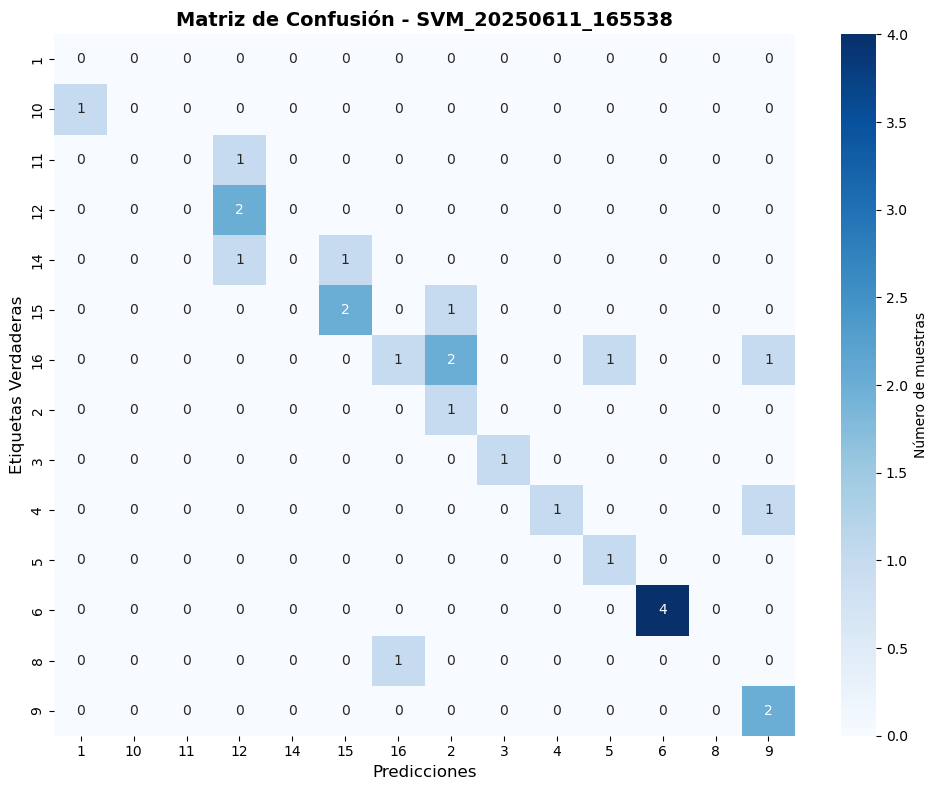


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (14, 14)
   🏷️  Etiquetas encontradas: ['1', '10', '11', '12', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   1  10  11  12  14  15  16  2  3  4  5  6  8  9
Verdadero                                                
1          0   0   0   0   0   0   0  0  0  0  0  0  0  0
10         1   0   0   0   0   0   0  0  0  0  0  0  0  0
11         0   0   0   1   0   0   0  0  0  0  0  0  0  0
12         0   0   0   2   0   0   0  0  0  0  0  0  0  0
14         0   0   0   1   0   1   0  0  0  0  0  0  0  0
15         0   0   0   0   0   2   0  1  0  0  0  0  0  0
16         0   0   0   0   0   0   1  2  0  0  1  0  0  1
2          0   0   0   0   0   0   0  1  0  0  0  0  0  0
3          0   0   0   0   0   0   0  0  1  0  0  0  0  0
4          0   0   0   0   0   0   0  0  0  1  0  0  0  1
5          0   0   0   0   0   0   0  0  0  0  1 

In [19]:
# Ejemplo 3: Comparar múltiples modelos
print("\\n" + "="*60)
print("EJEMPLO 3: Matriz de Confusión y Comparación de Modelos")

# Ejemplo de cómo usar la función:
results = generate_confusion_matrix(
    model_loader=loader,
    # model_folder="bert_10e_24b",
    model_folder="SVM_20250611_165538",
    dataset_path='./data/dataset_test.csv',
    save_plot=True,
    figsize=(10, 8)
)

# Acceder a los resultados
print("Accuracy:", results['accuracy'])
print("Matriz como DataFrame:")
print(results['confusion_matrix_df'])

print("✅ Función 'generate_confusion_matrix' creada exitosamente!")
print("\n📝 Características principales:")
print("   🔍 Detecta automáticamente el tipo de modelo")
print("   📊 Genera matriz de confusión visual con seaborn")
print("   💾 Opción para guardar el gráfico")
print("   📈 Calcula métricas básicas (accuracy, F1)")
print("   🏷️  Maneja automáticamente tipos mixtos de etiquetas")
print("   📋 Muestra estadísticas detalladas")

In [20]:
def evaluate_all_models(model_loader, dataset_path, text_column='text',
                       label_column='label', save_plots=True,
                       output_dir='./imgs'):
    """
    Evalúa todos los modelos cargados en el model_loader y genera sus matrices de confusión

    Args:
        model_loader: Instancia del cargador de modelos
        dataset_path: Ruta al archivo del dataset (CSV o JSON)
        text_column: Nombre de la columna de texto (default: 'text')
        label_column: Nombre de la columna de etiquetas (default: 'label')
        save_plots: Si guardar los gráficos como archivos (default: False)
        output_dir: Directorio donde guardar las matrices (default: './confusion_matrices')

    Returns:
        dict: Diccionario con resultados de todos los modelos
    """

    print(f"\n🚀 Evaluando TODOS los modelos cargados")
    print(f"   📁 Dataset: {dataset_path}")

    list_models = []
    folders = glob.glob("./models/traditional/*")
    for i in folders:
        list_models.append("traditional-" + i.split("\\")[-1])
    folders = glob.glob("./models/transformers/*")
    for i in folders:
        list_models.append("transformers-" + i.split("\\")[-1])
    
    print(f"   📊 Modelos disponibles: {list_models}")

    if len(list_models) == 0:
        print("❌ No hay modelos cargados. Carga algunos modelos primero.")
        return {}

    # Crear directorio de salida si se van a guardar plots
    if save_plots:
        os.makedirs(output_dir, exist_ok=True)
        print(f"   💾 Matrices se guardarán en: {output_dir}")

    all_results = {}
    summary_metrics = []

    print(f"\n" + "="*80)

    for type_and_model_name in list_models:
        model_type = type_and_model_name.split("-")[0]  # Extraer tipo de modelo
        model_name = type_and_model_name.split("-")[-1]  # Extraer solo el nombre del modelo
        print(f"\n🔍 Evaluando modelo: {model_name}")

        try:
            plot_filename = None
            if save_plots:
                plot_filename = f"{output_dir}/confusion_matrix_{model_name}.png"

            results = generate_confusion_matrix(
                model_loader=model_loader,
                model_folder=model_name,
                dataset_path=dataset_path,
                text_column=text_column,
                label_column=label_column,
                model_type=model_type,
                save_plot=save_plots,
                plot_filename=plot_filename,
                figsize=(8, 6)
            )

            all_results[model_name] = results

            # Guardar métricas para el resumen
            summary_metrics.append({
                'Modelo': model_name,
                'Tipo': model_type,
                'Accuracy': results['accuracy'],
                'F1-Score': results['f1_score'],
                'Num_Etiquetas': len(results['labels'])
            })

            print(f"✅ {model_name} evaluado exitosamente")

        except Exception as e:
            print(f"❌ Error evaluando {model_name}: {str(e)}")
            all_results[model_name] = {'error': str(e)}
        finally:
            print("-" * 50)

    # Crear resumen comparativo
    print(f"\n" + "="*80)
    print("📊 RESUMEN COMPARATIVO DE TODOS LOS MODELOS")
    print("="*80)

    if summary_metrics:
        summary_df = pd.DataFrame(summary_metrics)
        summary_df = summary_df.sort_values('Accuracy', ascending=False)

        print("\n🏆 Ranking por Accuracy:")
        print(summary_df.to_string(index=False, float_format='%.4f'))

        # Gráfico comparativo
        plt.figure(figsize=(12, 6))

        # Subplot 1: Accuracy
        plt.subplot(1, 2, 1)
        bars1 = plt.bar(summary_df['Modelo'], summary_df['Accuracy'],
                       color='skyblue', alpha=0.7)
        plt.title('Accuracy por Modelo', fontweight='bold')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=90)
        plt.ylim(0, 1)

        # Añadir valores en las barras
        for bar, acc in zip(bars1, summary_df['Accuracy']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')

        # Subplot 2: F1-Score
        plt.subplot(1, 2, 2)
        bars2 = plt.bar(summary_df['Modelo'], summary_df['F1-Score'],
                       color='lightcoral', alpha=0.7)
        plt.title('F1-Score por Modelo', fontweight='bold')
        plt.ylabel('F1-Score')
        plt.xticks(rotation=90)
        plt.ylim(0, 1)

        # Añadir valores en las barras
        for bar, f1 in zip(bars2, summary_df['F1-Score']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.3f}', ha='center', va='bottom')

        plt.tight_layout()

        if save_plots:
            comparison_file = f"{output_dir}/models_comparison.png"
            plt.savefig(comparison_file, dpi=300, bbox_inches='tight')
            print(f"\n💾 Gráfico comparativo guardado: {comparison_file}")

        plt.show()

        # Encontrar el mejor modelo
        best_model = summary_df.iloc[0]
        print(f"\n🥇 MEJOR MODELO:")
        print(f"   🏆 Nombre: {best_model['Modelo']}")
        print(f"   🎯 Accuracy: {best_model['Accuracy']:.4f}")
        print(f"   📈 F1-Score: {best_model['F1-Score']:.4f}")
        print(f"   🔧 Tipo: {best_model['Tipo']}")

        all_results['summary'] = {
            'summary_df': summary_df,
            'best_model': best_model.to_dict(),
            'total_models_evaluated': len(summary_metrics)
        }

    print(f"\n✅ Evaluación completa de {len(all_results)} modelos terminada")

    return all_results


def evaluate_top_k_accuracy(model_loader, model_folder, dataset_path, k=3,
                           text_column='text', label_column='label',
                           model_type='auto', verbose=True):
    """
    Evalúa si la etiqueta verdadera está entre las top-k predicciones con mayor probabilidad

    Args:
        model_loader: Instancia del cargador de modelos
        model_folder: Nombre de la carpeta del modelo
        dataset_path: Ruta al archivo del dataset (CSV o JSON)
        k: Número de predicciones top a considerar (default: 3)
        text_column: Nombre de la columna de texto (default: 'text')
        label_column: Nombre de la columna de etiquetas (default: 'label')
        model_type: Tipo de modelo ('auto', 'traditional', 'transformer')
        verbose: Si mostrar información detallada (default: True)

    Returns:
        dict: Diccionario con métricas de top-k accuracy
    """

    if verbose:
        print(f"\n🎯 Evaluando Top-{k} Accuracy para: {model_folder}")
        print(f"   📁 Dataset: {dataset_path}")

    # Cargar dataset
    if dataset_path.endswith('.csv'):
        df = read_csv_dataset(dataset_path, only_first_label=True, only_last_label=False)
    elif dataset_path.endswith('.json'):
        df = pd.read_json(dataset_path)
    else:
        raise ValueError("Formato de archivo no soportado. Use CSV o JSON.")

    texts = df[text_column].astype(str).tolist()
    true_labels = df[label_column].tolist()

    if verbose:
        print(f"   📊 Dataset cargado: {len(texts)} muestras")

    # Detectar tipo de modelo si es automático
    if model_type == 'auto':
        if model_folder in model_loader.loaded_models:
            model_type = model_loader.loaded_models[model_folder]['type']
        else:
            if os.path.exists(f"{model_loader.models_dir}/traditional/{model_folder}"):
                model_type = 'traditional'
            elif os.path.exists(f"{model_loader.models_dir}/transformers/{model_folder}"):
                model_type = 'transformer'
            else:
                raise ValueError(f"No se pudo detectar el tipo de modelo para: {model_folder}")

    # Hacer predicciones
    print("Prediciendo etiquetas...")
    if model_type == 'traditional':
        predictions, probabilities = model_loader.predict_traditional(model_folder, texts)
        predictions = [str(pred) for pred in predictions]
    else:
        predictions, probabilities = model_loader.predict_transformer(model_folder, texts)
        predictions = [str(pred+1) for pred in predictions]

    # Convertir etiquetas a string para consistencia
    true_labels = [str(label) for label in true_labels]

    # Calcular Top-1 accuracy (accuracy normal)
    top1_correct = sum(1 for true, pred in zip(true_labels, predictions) if true == pred)
    top1_accuracy = top1_correct / len(true_labels)

    # Calcular Top-k accuracy
    topk_correct = 0
    detailed_results = []

    # Obtener las clases únicas para mapear índices
    if hasattr(model_loader.loaded_models[model_folder]['model'], 'classes_'):
        classes = model_loader.loaded_models[model_folder]['model'].classes_
    else:
        # Para modelos transformer, necesitamos obtener las clases de otra manera
        classes = sorted(list(set(true_labels + predictions)))
        classes = sorted(list(set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])))

    classes = [str(c) for c in classes]  # Asegurar que sean strings

    print(f"   🏷️ Clases detectadas: {len(classes)} clases únicas")
    # print("clases", classes)
    # print("true_labels", true_labels)
    # print(len(true_labels))

    for i, (true_label, prob_array) in enumerate(zip(true_labels, probabilities)):
        # Obtener los índices de las k probabilidades más altas
        ## Esto era cuando se retornaba un numpy array 2D ----------------------------------------------
        # if len(prob_array.shape) > 1:
        #     prob_array = prob_array[0]  # Si es 2D, tomar la primera fila
        # -----------------------------------------------------------------------------------------------

        top_k_indices = np.argsort(prob_array)[-k:][::-1]  # Índices ordenados descendente
        # print("top_k_indices", top_k_indices)
        top_k_classes = [classes[idx] for idx in top_k_indices]
        top_k_probs = [prob_array[idx] for idx in top_k_indices]
        # print("top_k_classes", top_k_classes)
        # print("top_k_probs", top_k_probs)

        # Verificar si la etiqueta verdadera está en el top-k
        is_in_topk = true_label in top_k_classes
        if is_in_topk:
            topk_correct += 1

        detailed_results.append({
            'sample_idx': i,
            'true_label': true_label,
            'top_prediction': predictions[i],
            f'top_{k}_classes': top_k_classes,
            f'top_{k}_probabilities': top_k_probs,
            f'in_top_{k}': is_in_topk
        })

    topk_accuracy = topk_correct / len(true_labels)

    if verbose:
        print(f"\n📈 Resultados Top-{k} Accuracy:")
        print(f"   🎯 Top-1 Accuracy: {top1_accuracy:.4f} ({top1_correct}/{len(true_labels)})")
        print(f"   🏆 Top-{k} Accuracy: {topk_accuracy:.4f} ({topk_correct}/{len(true_labels)})")
        print(f"   📊 Mejora: +{(topk_accuracy - top1_accuracy):.4f} ({((topk_accuracy - top1_accuracy) / top1_accuracy * 100):.1f}%)")

        # Mostrar algunos ejemplos donde top-k ayudó
        helped_cases = [r for r in detailed_results if r[f'in_top_{k}'] and r['true_label'] != r['top_prediction']]
        if helped_cases and len(helped_cases) > 0:
            print(f"\n💡 Ejemplos donde Top-{k} ayudó (primeros 3):")
            for case in helped_cases[:3]:
                print(f"   📝 Muestra {case['sample_idx']}: Verdadero='{case['true_label']}', "
                      f"Predicho='{case['top_prediction']}', Top-{k}={case[f'top_{k}_classes']}")

    return {
        'top1_accuracy': top1_accuracy,
        f'top{k}_accuracy': topk_accuracy,
        'improvement': topk_accuracy - top1_accuracy,
        'improvement_percentage': ((topk_accuracy - top1_accuracy) / top1_accuracy * 100) if top1_accuracy > 0 else 0,
        'total_samples': len(true_labels),
        'top1_correct': top1_correct,
        f'top{k}_correct': topk_correct,
        'detailed_results': detailed_results,
        'k': k
    }

In [21]:
for model_name in loader.loaded_models:# loader no carga los modelos, sino es con su metodo
    print("="*60)
    print(f"🔍 Evaluando modelo: {model_name}")

🔍 Evaluando modelo: SVM
🔍 Evaluando modelo: SVM_20250611_165538


✅ Funciones creadas exitosamente!

📝 Funciones disponibles:

🚀 Evaluando TODOS los modelos cargados
   📁 Dataset: ./data/dataset_test.csv
   📊 Modelos disponibles: ['traditional-Logistic_Regression', 'traditional-Logistic_Regression_20250611_165546', 'traditional-Random_Forest', 'traditional-Random_Forest_20250611_165936', 'traditional-SVM', 'traditional-SVM_20250611_165538', 'transformers-bert_10e_24b', 'transformers-bert_5e_16b', 'transformers-distilbert_10e_24b_0', 'transformers-distilbert_10e_24b_1', 'transformers-distilbert_5e_16b', 'transformers-roberta_5e_16b', 'transformers-roberta_6ta_10e_24b']
   💾 Matrices se guardarán en: ./imgs


🔍 Evaluando modelo: Logistic_Regression

🔍 Generando matriz de confusión para: Logistic_Regression
   📁 Dataset: ./data/dataset_test.csv
   📊 Dataset cargado: 26 muestras
🔍 Cargando modelo tradicional: Logistic_Regression
📥 Cargando modelo tradicional: Logistic_Regression
   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.7887
🔍 Procesando 26 

c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.6.


📈 Métricas del modelo:
   🎯 Accuracy: 0.5385
   📊 F1-Score: 0.5018
   💾 Matriz guardada como: ./imgs/confusion_matrix_Logistic_Regression.png


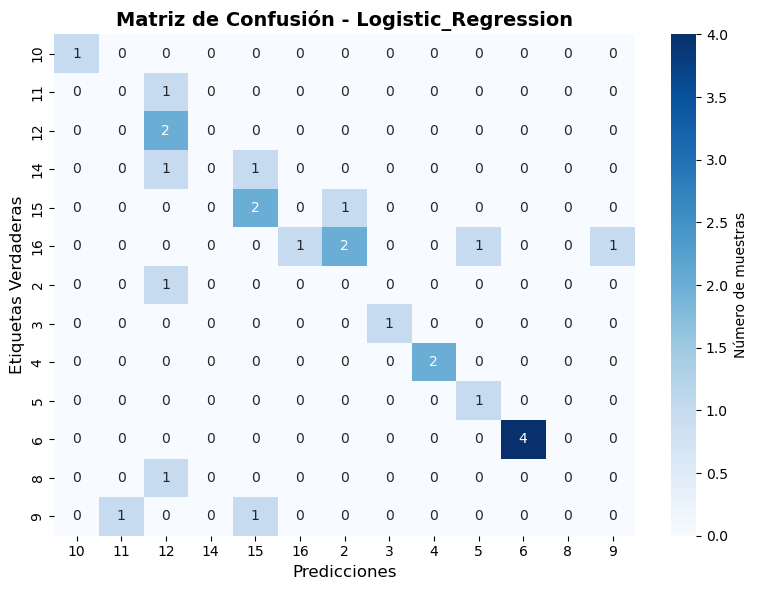


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (13, 13)
   🏷️  Etiquetas encontradas: ['10', '11', '12', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  12  14  15  16  2  3  4  5  6  8  9
Verdadero                                             
10          1   0   0   0   0   0  0  0  0  0  0  0  0
11          0   0   1   0   0   0  0  0  0  0  0  0  0
12          0   0   2   0   0   0  0  0  0  0  0  0  0
14          0   0   1   0   1   0  0  0  0  0  0  0  0
15          0   0   0   0   2   0  1  0  0  0  0  0  0
16          0   0   0   0   0   1  2  0  0  1  0  0  1
2           0   0   1   0   0   0  0  0  0  0  0  0  0
3           0   0   0   0   0   0  0  1  0  0  0  0  0
4           0   0   0   0   0   0  0  0  2  0  0  0  0
5           0   0   0   0   0   0  0  0  0  1  0  0  0
6           0   0   0   0   0   0  0  0  0  0  4  0  0
8           0   0   1   0   0   0  

c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.6.


📈 Métricas del modelo:
   🎯 Accuracy: 0.6154
   📊 F1-Score: 0.5612
   💾 Matriz guardada como: ./imgs/confusion_matrix_Logistic_Regression_20250611_165546.png


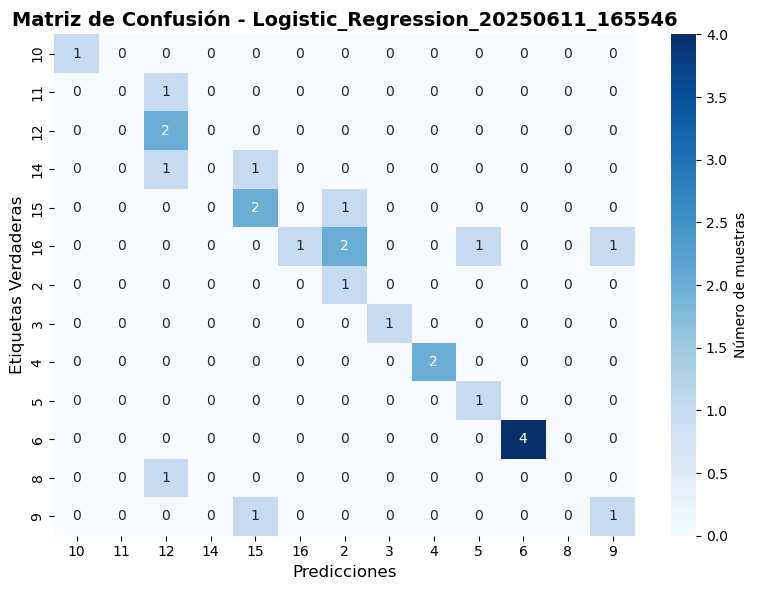


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (13, 13)
   🏷️  Etiquetas encontradas: ['10', '11', '12', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  12  14  15  16  2  3  4  5  6  8  9
Verdadero                                             
10          1   0   0   0   0   0  0  0  0  0  0  0  0
11          0   0   1   0   0   0  0  0  0  0  0  0  0
12          0   0   2   0   0   0  0  0  0  0  0  0  0
14          0   0   1   0   1   0  0  0  0  0  0  0  0
15          0   0   0   0   2   0  1  0  0  0  0  0  0
16          0   0   0   0   0   1  2  0  0  1  0  0  1
2           0   0   0   0   0   0  1  0  0  0  0  0  0
3           0   0   0   0   0   0  0  1  0  0  0  0  0
4           0   0   0   0   0   0  0  0  2  0  0  0  0
5           0   0   0   0   0   0  0  0  0  1  0  0  0
6           0   0   0   0   0   0  0  0  0  0  4  0  0
8           0   0   1   0   0   0  

c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from v

   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.8540
🔍 Procesando 26 textos para predicción...

📈 Métricas del modelo:
   🎯 Accuracy: 0.4615
   📊 F1-Score: 0.4470
   💾 Matriz guardada como: ./imgs/confusion_matrix_Random_Forest.png


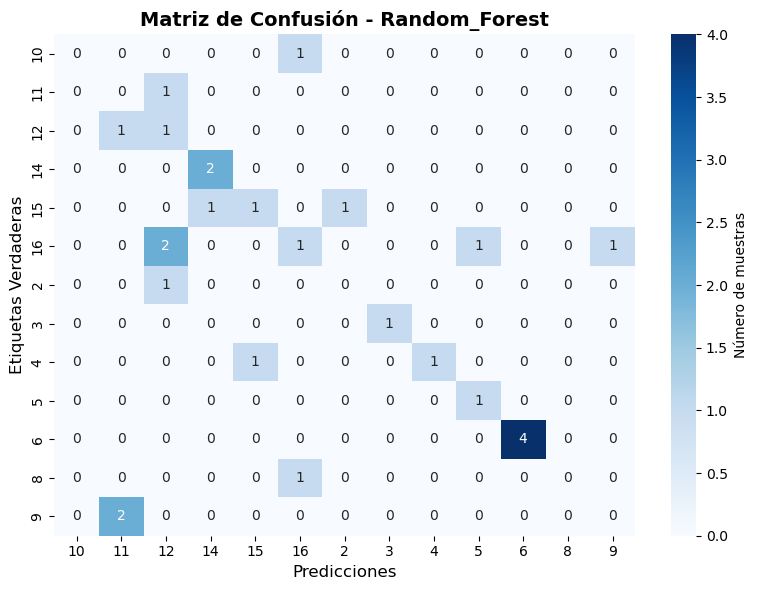


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (13, 13)
   🏷️  Etiquetas encontradas: ['10', '11', '12', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  12  14  15  16  2  3  4  5  6  8  9
Verdadero                                             
10          0   0   0   0   0   1  0  0  0  0  0  0  0
11          0   0   1   0   0   0  0  0  0  0  0  0  0
12          0   1   1   0   0   0  0  0  0  0  0  0  0
14          0   0   0   2   0   0  0  0  0  0  0  0  0
15          0   0   0   1   1   0  1  0  0  0  0  0  0
16          0   0   2   0   0   1  0  0  0  1  0  0  1
2           0   0   1   0   0   0  0  0  0  0  0  0  0
3           0   0   0   0   0   0  0  1  0  0  0  0  0
4           0   0   0   0   1   0  0  0  1  0  0  0  0
5           0   0   0   0   0   0  0  0  0  1  0  0  0
6           0   0   0   0   0   0  0  0  0  0  4  0  0
8           0   0   0   0   0   1  

c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from v

   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.8514
🔍 Procesando 26 textos para predicción...

📈 Métricas del modelo:
   🎯 Accuracy: 0.5000
   📊 F1-Score: 0.4583
   💾 Matriz guardada como: ./imgs/confusion_matrix_Random_Forest_20250611_165936.png


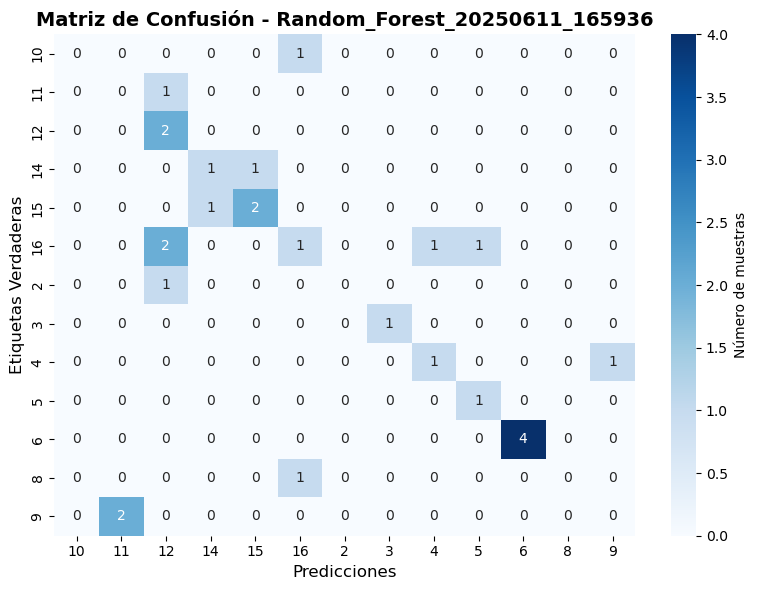


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (13, 13)
   🏷️  Etiquetas encontradas: ['10', '11', '12', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  12  14  15  16  2  3  4  5  6  8  9
Verdadero                                             
10          0   0   0   0   0   1  0  0  0  0  0  0  0
11          0   0   1   0   0   0  0  0  0  0  0  0  0
12          0   0   2   0   0   0  0  0  0  0  0  0  0
14          0   0   0   1   1   0  0  0  0  0  0  0  0
15          0   0   0   1   2   0  0  0  0  0  0  0  0
16          0   0   2   0   0   1  0  0  1  1  0  0  0
2           0   0   1   0   0   0  0  0  0  0  0  0  0
3           0   0   0   0   0   0  0  1  0  0  0  0  0
4           0   0   0   0   0   0  0  0  1  0  0  0  1
5           0   0   0   0   0   0  0  0  0  1  0  0  0
6           0   0   0   0   0   0  0  0  0  0  4  0  0
8           0   0   0   0   0   1  

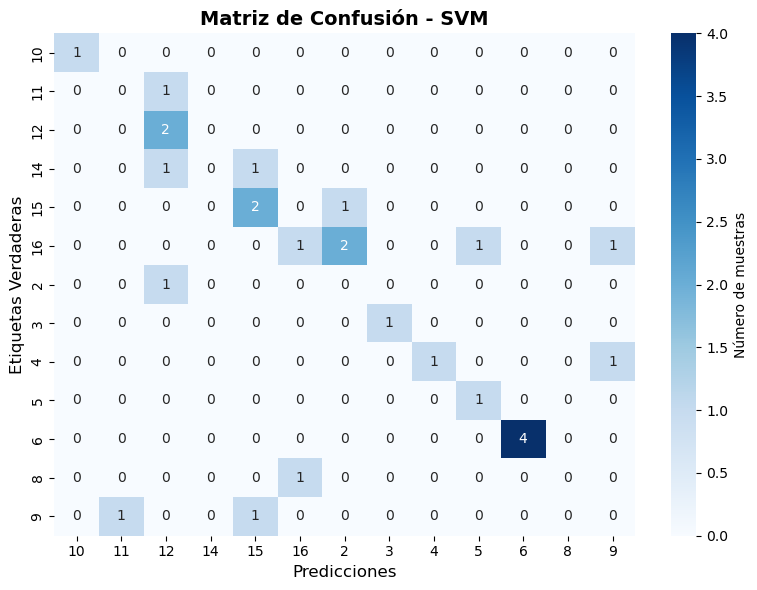


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (13, 13)
   🏷️  Etiquetas encontradas: ['10', '11', '12', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  12  14  15  16  2  3  4  5  6  8  9
Verdadero                                             
10          1   0   0   0   0   0  0  0  0  0  0  0  0
11          0   0   1   0   0   0  0  0  0  0  0  0  0
12          0   0   2   0   0   0  0  0  0  0  0  0  0
14          0   0   1   0   1   0  0  0  0  0  0  0  0
15          0   0   0   0   2   0  1  0  0  0  0  0  0
16          0   0   0   0   0   1  2  0  0  1  0  0  1
2           0   0   1   0   0   0  0  0  0  0  0  0  0
3           0   0   0   0   0   0  0  1  0  0  0  0  0
4           0   0   0   0   0   0  0  0  1  0  0  0  1
5           0   0   0   0   0   0  0  0  0  1  0  0  0
6           0   0   0   0   0   0  0  0  0  0  4  0  0
8           0   0   0   0   0   1  

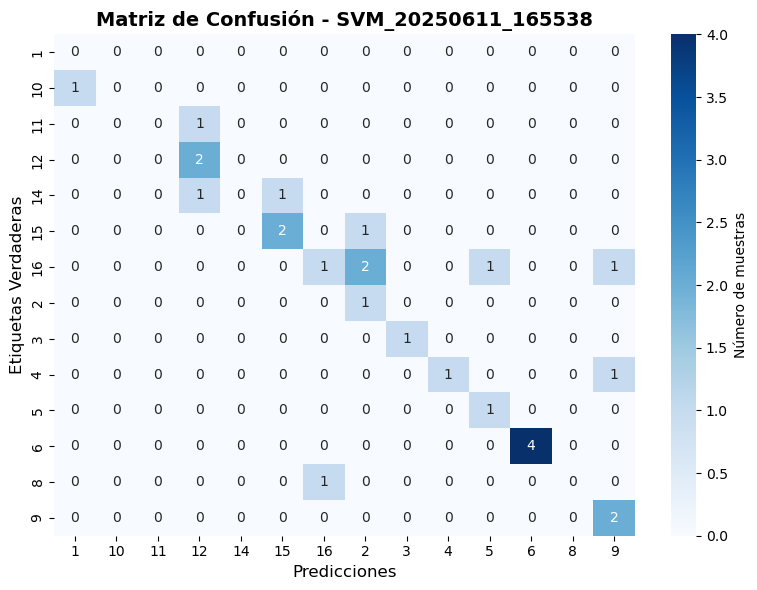


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (14, 14)
   🏷️  Etiquetas encontradas: ['1', '10', '11', '12', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   1  10  11  12  14  15  16  2  3  4  5  6  8  9
Verdadero                                                
1          0   0   0   0   0   0   0  0  0  0  0  0  0  0
10         1   0   0   0   0   0   0  0  0  0  0  0  0  0
11         0   0   0   1   0   0   0  0  0  0  0  0  0  0
12         0   0   0   2   0   0   0  0  0  0  0  0  0  0
14         0   0   0   1   0   1   0  0  0  0  0  0  0  0
15         0   0   0   0   0   2   0  1  0  0  0  0  0  0
16         0   0   0   0   0   0   1  2  0  0  1  0  0  1
2          0   0   0   0   0   0   0  1  0  0  0  0  0  0
3          0   0   0   0   0   0   0  0  1  0  0  0  0  0
4          0   0   0   0   0   0   0  0  0  1  0  0  0  1
5          0   0   0   0   0   0   0  0  0  0  1 

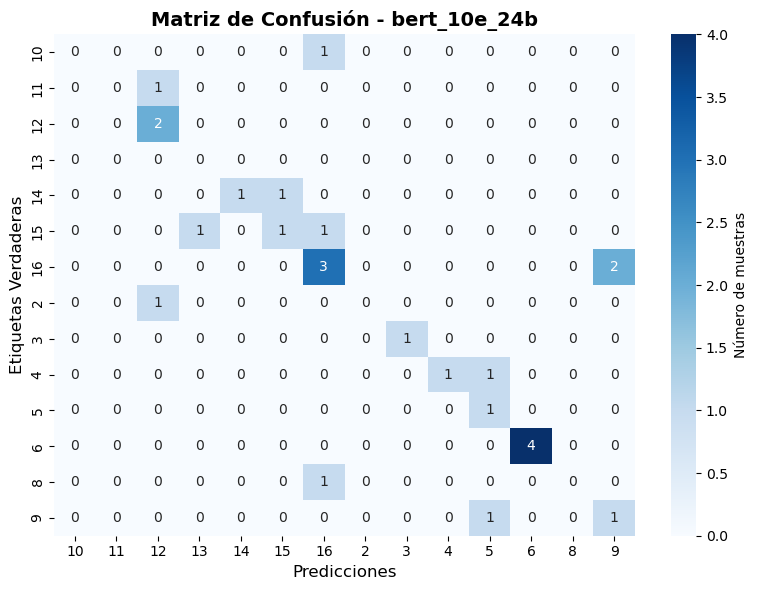


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (14, 14)
   🏷️  Etiquetas encontradas: ['10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  12  13  14  15  16  2  3  4  5  6  8  9
Verdadero                                                 
10          0   0   0   0   0   0   1  0  0  0  0  0  0  0
11          0   0   1   0   0   0   0  0  0  0  0  0  0  0
12          0   0   2   0   0   0   0  0  0  0  0  0  0  0
13          0   0   0   0   0   0   0  0  0  0  0  0  0  0
14          0   0   0   0   1   1   0  0  0  0  0  0  0  0
15          0   0   0   1   0   1   1  0  0  0  0  0  0  0
16          0   0   0   0   0   0   3  0  0  0  0  0  0  2
2           0   0   1   0   0   0   0  0  0  0  0  0  0  0
3           0   0   0   0   0   0   0  0  1  0  0  0  0  0
4           0   0   0   0   0   0   0  0  0  1  1  0  0  0
5           0   0   0   0   0   0   

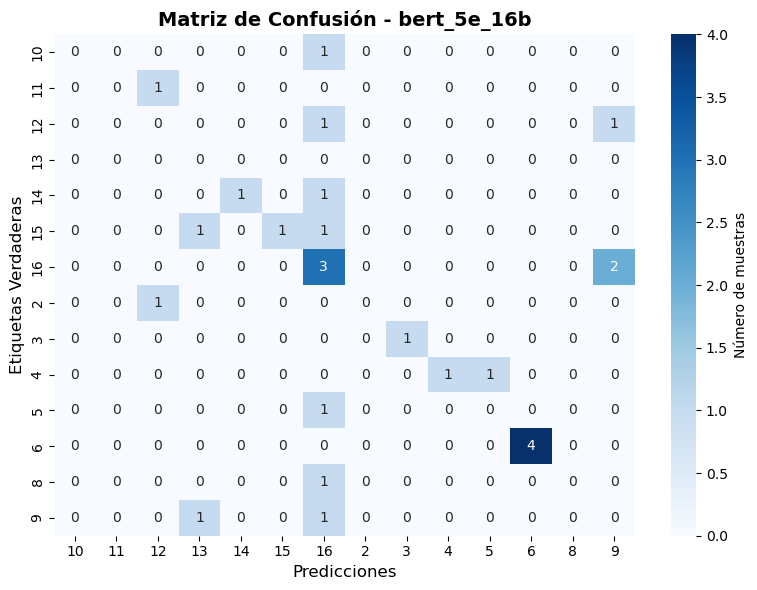


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (14, 14)
   🏷️  Etiquetas encontradas: ['10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  12  13  14  15  16  2  3  4  5  6  8  9
Verdadero                                                 
10          0   0   0   0   0   0   1  0  0  0  0  0  0  0
11          0   0   1   0   0   0   0  0  0  0  0  0  0  0
12          0   0   0   0   0   0   1  0  0  0  0  0  0  1
13          0   0   0   0   0   0   0  0  0  0  0  0  0  0
14          0   0   0   0   1   0   1  0  0  0  0  0  0  0
15          0   0   0   1   0   1   1  0  0  0  0  0  0  0
16          0   0   0   0   0   0   3  0  0  0  0  0  0  2
2           0   0   1   0   0   0   0  0  0  0  0  0  0  0
3           0   0   0   0   0   0   0  0  1  0  0  0  0  0
4           0   0   0   0   0   0   0  0  0  1  1  0  0  0
5           0   0   0   0   0   0   

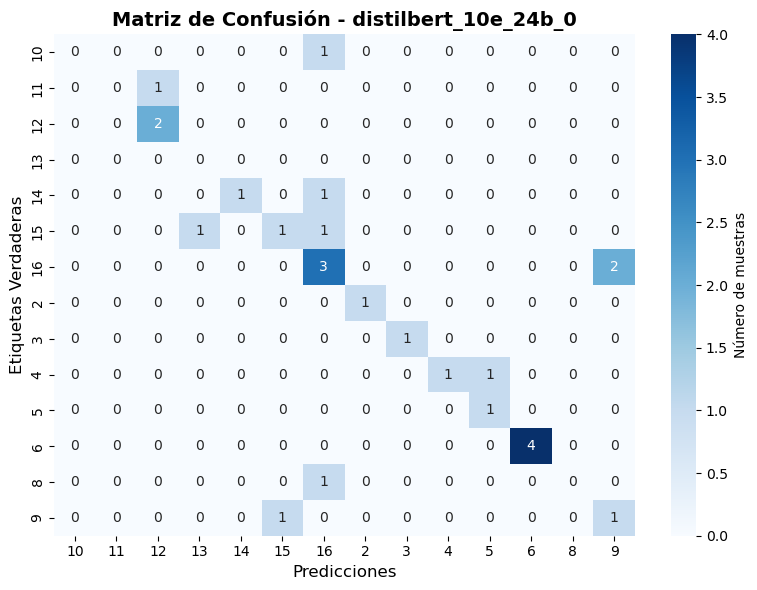


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (14, 14)
   🏷️  Etiquetas encontradas: ['10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  12  13  14  15  16  2  3  4  5  6  8  9
Verdadero                                                 
10          0   0   0   0   0   0   1  0  0  0  0  0  0  0
11          0   0   1   0   0   0   0  0  0  0  0  0  0  0
12          0   0   2   0   0   0   0  0  0  0  0  0  0  0
13          0   0   0   0   0   0   0  0  0  0  0  0  0  0
14          0   0   0   0   1   0   1  0  0  0  0  0  0  0
15          0   0   0   1   0   1   1  0  0  0  0  0  0  0
16          0   0   0   0   0   0   3  0  0  0  0  0  0  2
2           0   0   0   0   0   0   0  1  0  0  0  0  0  0
3           0   0   0   0   0   0   0  0  1  0  0  0  0  0
4           0   0   0   0   0   0   0  0  0  1  1  0  0  0
5           0   0   0   0   0   0   

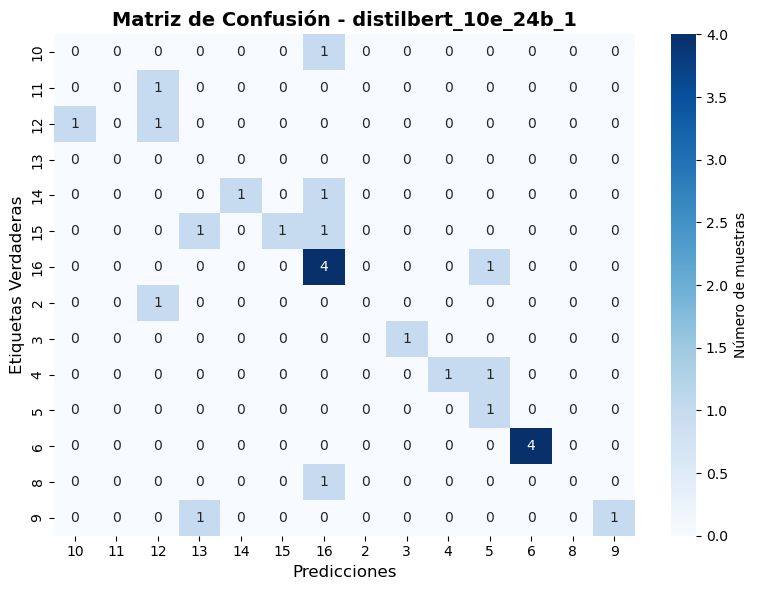


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (14, 14)
   🏷️  Etiquetas encontradas: ['10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  12  13  14  15  16  2  3  4  5  6  8  9
Verdadero                                                 
10          0   0   0   0   0   0   1  0  0  0  0  0  0  0
11          0   0   1   0   0   0   0  0  0  0  0  0  0  0
12          1   0   1   0   0   0   0  0  0  0  0  0  0  0
13          0   0   0   0   0   0   0  0  0  0  0  0  0  0
14          0   0   0   0   1   0   1  0  0  0  0  0  0  0
15          0   0   0   1   0   1   1  0  0  0  0  0  0  0
16          0   0   0   0   0   0   4  0  0  0  1  0  0  0
2           0   0   1   0   0   0   0  0  0  0  0  0  0  0
3           0   0   0   0   0   0   0  0  1  0  0  0  0  0
4           0   0   0   0   0   0   0  0  0  1  1  0  0  0
5           0   0   0   0   0   0   

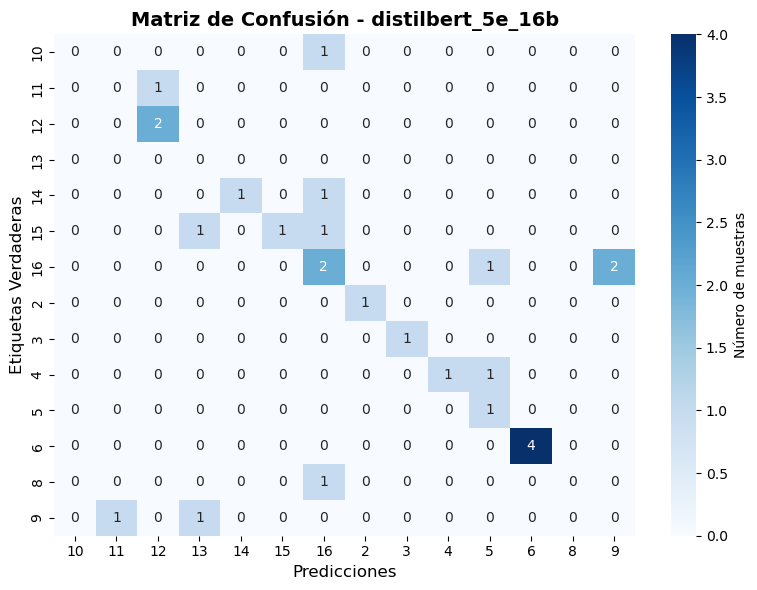


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (14, 14)
   🏷️  Etiquetas encontradas: ['10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  12  13  14  15  16  2  3  4  5  6  8  9
Verdadero                                                 
10          0   0   0   0   0   0   1  0  0  0  0  0  0  0
11          0   0   1   0   0   0   0  0  0  0  0  0  0  0
12          0   0   2   0   0   0   0  0  0  0  0  0  0  0
13          0   0   0   0   0   0   0  0  0  0  0  0  0  0
14          0   0   0   0   1   0   1  0  0  0  0  0  0  0
15          0   0   0   1   0   1   1  0  0  0  0  0  0  0
16          0   0   0   0   0   0   2  0  0  0  1  0  0  2
2           0   0   0   0   0   0   0  1  0  0  0  0  0  0
3           0   0   0   0   0   0   0  0  1  0  0  0  0  0
4           0   0   0   0   0   0   0  0  0  1  1  0  0  0
5           0   0   0   0   0   0   

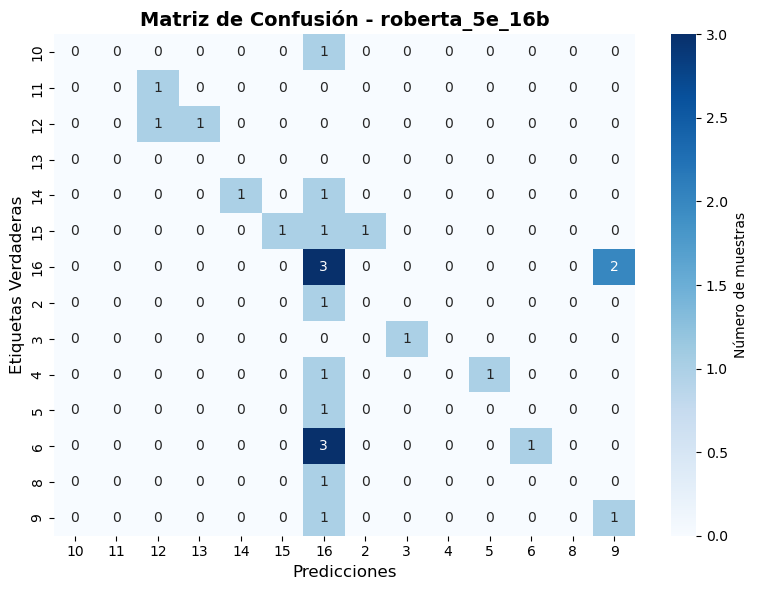


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (14, 14)
   🏷️  Etiquetas encontradas: ['10', '11', '12', '13', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  12  13  14  15  16  2  3  4  5  6  8  9
Verdadero                                                 
10          0   0   0   0   0   0   1  0  0  0  0  0  0  0
11          0   0   1   0   0   0   0  0  0  0  0  0  0  0
12          0   0   1   1   0   0   0  0  0  0  0  0  0  0
13          0   0   0   0   0   0   0  0  0  0  0  0  0  0
14          0   0   0   0   1   0   1  0  0  0  0  0  0  0
15          0   0   0   0   0   1   1  1  0  0  0  0  0  0
16          0   0   0   0   0   0   3  0  0  0  0  0  0  2
2           0   0   0   0   0   0   1  0  0  0  0  0  0  0
3           0   0   0   0   0   0   0  0  1  0  0  0  0  0
4           0   0   0   0   0   0   1  0  0  0  1  0  0  0
5           0   0   0   0   0   0   

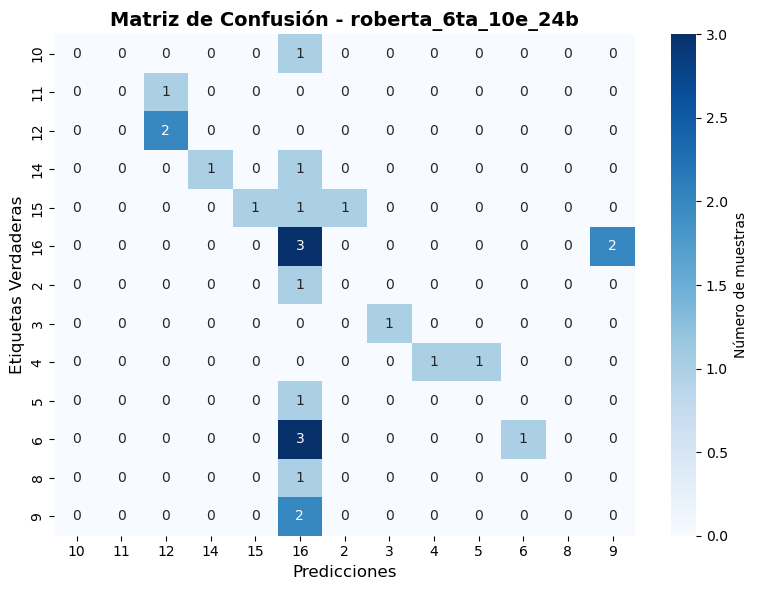


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (13, 13)
   🏷️  Etiquetas encontradas: ['10', '11', '12', '14', '15', '16', '2', '3', '4', '5', '6', '8', '9']
   📈 Total de predicciones: 26

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  12  14  15  16  2  3  4  5  6  8  9
Verdadero                                             
10          0   0   0   0   0   1  0  0  0  0  0  0  0
11          0   0   1   0   0   0  0  0  0  0  0  0  0
12          0   0   2   0   0   0  0  0  0  0  0  0  0
14          0   0   0   1   0   1  0  0  0  0  0  0  0
15          0   0   0   0   1   1  1  0  0  0  0  0  0
16          0   0   0   0   0   3  0  0  0  0  0  0  2
2           0   0   0   0   0   1  0  0  0  0  0  0  0
3           0   0   0   0   0   0  0  1  0  0  0  0  0
4           0   0   0   0   0   0  0  0  1  1  0  0  0
5           0   0   0   0   0   1  0  0  0  0  0  0  0
6           0   0   0   0   0   3  0  0  0  0  1  0  0
8           0   0   0   0   0   1  

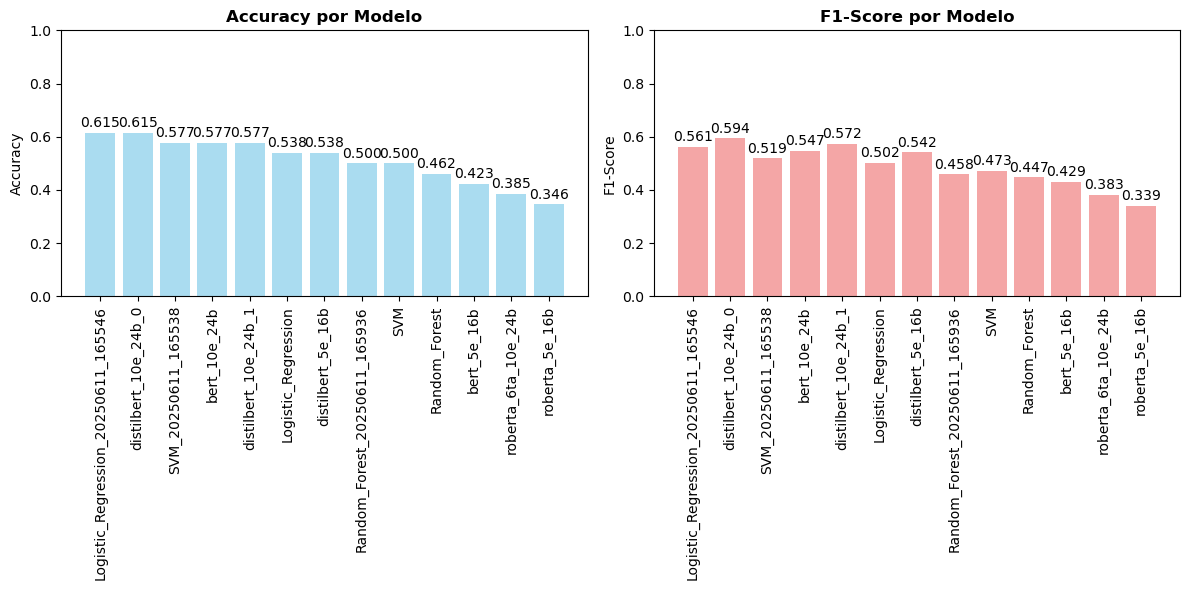


🥇 MEJOR MODELO:
   🏆 Nombre: Logistic_Regression_20250611_165546
   🎯 Accuracy: 0.6154
   📈 F1-Score: 0.5612
   🔧 Tipo: traditional

✅ Evaluación completa de 14 modelos terminada


{'Logistic_Regression': {'confusion_matrix': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 1],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64),
  'labels': ['10',
   '11',
   '12',
   '14',
   '15',
   '16',
   '2',
   '3',
   '4',
   '5',
   '6',
   '8',
   '9'],
  'accuracy': 0.5384615384615384,
  'f1_score': 0.5018315018315017,
  'predictions': ['2',
   '12',
   '9',
   '4',
   '2',
   '6',
   '3',
   '4',
   '5',
   '5',
   '6',

In [22]:
print("✅ Funciones creadas exitosamente!")
print("\n📝 Funciones disponibles:")
evaluate_all_models(model_loader=loader, dataset_path='./data/dataset_test.csv')

In [ ]:
print("   🚀  - Evalúa todos los modelos cargados")
evaluate_top_k_accuracy(
    model_loader=loader,
    # model_folder="bert_5e_16b", # 0.4231 (11/26)  -  0.7692 (20/26) # 6.8s
    # model_folder="bert_10e_24b",  # 0.5769 (15/26) - 0.8077 (21/26) # 6.2s
    # model_folder="roberta_5e_16b", # 0.3462 (9/26)  -  0.8077 (21/26) # 7.7s
    # model_folder="roberta_6ta_10e_24b", # 0.3846 (10/26)  -  0.8077 (21/26) # 6.3s
    # model_folder="distilbert_5e_16b", # 0.5385 (14/26)  -  0.8077 (21/26) # 4.4s
    # model_folder="distilbert_10e_24b_0", #  0.6154 (16/26)  -  0.7308 (19/26) # 3.6s
    # model_folder="SVM",  # 0.5000 (13/26)  -  0.9231 (24/26) # 2.1s
    # model_folder="SVM_20250611_165538",  #  0.5769 (15/26)  -  0.8462 (22/26) # 2.1s
    # model_folder="Random_Forest",  # 0.4615 (12/26)  -   0.7692 (20/26)  # 4.6s
    # model_folder="Random_Forest_20250611_165936",  #  0.5000 (13/26)  -  0.8077 (21/26) # 0.9s
    # model_folder="Logistic_Regression_20250611_165546",  #  0.6154 (16/26)  -  0.8077 (21/26) # 0.9s
    model_folder="Logistic_Regression",  #  0.5385 (14/26)  -  0.8077 (21/26) # 0.7s
    dataset_path='./data/dataset_test.csv')

   🚀  - Evalúa todos los modelos cargados

🎯 Evaluando Top-3 Accuracy para: Logistic_Regression
   📁 Dataset: ./data/dataset_test.csv
   📊 Dataset cargado: 26 muestras
Prediciendo etiquetas...
🔍 Cargando modelo tradicional: Logistic_Regression
🔍 Procesando 26 textos para predicción...
   🏷️ Clases detectadas: 16 clases únicas

📈 Resultados Top-3 Accuracy:
   🎯 Top-1 Accuracy: 0.5385 (14/26)
   🏆 Top-3 Accuracy: 0.8077 (21/26)
   📊 Mejora: +0.2692 (50.0%)

💡 Ejemplos donde Top-3 ayudó (primeros 3):
   📝 Muestra 2: Verdadero='16', Predicho='9', Top-3=['9', '12', '16']
   📝 Muestra 8: Verdadero='16', Predicho='5', Top-3=['5', '8', '16']
   📝 Muestra 11: Verdadero='2', Predicho='12', Top-3=['12', '2', '14']


{'top1_accuracy': 0.5384615384615384,
 'top3_accuracy': 0.8076923076923077,
 'improvement': 0.2692307692307693,
 'improvement_percentage': 50.000000000000014,
 'total_samples': 26,
 'top1_correct': 14,
 'top3_correct': 21,
 'detailed_results': [{'sample_idx': 0,
   'true_label': '16',
   'top_prediction': '2',
   'top_3_classes': ['2', '12', '14'],
   'top_3_probabilities': [0.5307071433186376,
    0.21553520622136366,
    0.08571259059715021],
   'in_top_3': False},
  {'sample_idx': 1,
   'true_label': '12',
   'top_prediction': '12',
   'top_3_classes': ['12', '8', '9'],
   'top_3_probabilities': [0.4987436822593143,
    0.10720125203389003,
    0.06679436302456479],
   'in_top_3': True},
  {'sample_idx': 2,
   'true_label': '16',
   'top_prediction': '9',
   'top_3_classes': ['9', '12', '16'],
   'top_3_probabilities': [0.4766111781802821,
    0.18076272785469996,
    0.09522844960540448],
   'in_top_3': True},
  {'sample_idx': 3,
   'true_label': '4',
   'top_prediction': '4',
   '

In [24]:

print("\n💡 Ejemplos de uso:")
print("   ")
print("   # Evaluar top-3 accuracy de un modelo específico")
print("   top3_results = evaluate_top_k_accuracy(loader, 'SVM', './data/dataset_test.csv', k=3)")


💡 Ejemplos de uso:
   
   # Evaluar top-3 accuracy de un modelo específico
   top3_results = evaluate_top_k_accuracy(loader, 'SVM', './data/dataset_test.csv', k=3)


# load_models

In [25]:
def load_traditional_model(model_dir):
    """Carga modelo tradicional guardado"""
    model_path = f"{model_dir}/model.pkl"
    vectorizer_path = f"{model_dir}/vectorizer.pkl"
    metadata_path = f"{model_dir}/metadata.json"

    model = joblib.load(model_path)
    vectorizer = joblib.load(vectorizer_path)

    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    return model, vectorizer, metadata

In [26]:
def load_transformer_model(model_dir):
    """Carga modelo transformer guardado"""
    metadata_path = f"{model_dir}/metadata.json"

    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)

    return model, tokenizer, metadata

### Primeros pasos

In [27]:
models_dir = "./models/*"
list_dir = glob.glob(models_dir)
models_upload = {}


In [28]:
folders = glob.glob("./models/traditional/*")
for i in folders:
    print(i.split("\\")[-1])
    models_upload[i.split("\\")[-1]] = load_traditional_model(i.replace("\\", "/"))

Logistic_Regression


c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.6.

Logistic_Regression_20250611_165546
Random_Forest


c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Random_Forest_20250611_165936
SVM
SVM_20250611_165538


c:\Users\saraujo\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [29]:
folders = glob.glob("./models/transformers/*")
for i in folders:
    print(i.split("\\")[-1])
    models_upload[i.split("\\")[-1]] = load_transformer_model(i.replace("\\", "/"))

bert_10e_24b
bert_5e_16b
distilbert_10e_24b_0
distilbert_10e_24b_1
distilbert_5e_16b
roberta_5e_16b
roberta_6ta_10e_24b


In [30]:
models_upload['SVM']

(SVC(probability=True, random_state=42),
 TfidfVectorizer(max_features=10000, stop_words='english'),
 {'model_name': 'SVM',
  'timestamp': '20250611_123041',
  'val_accuracy': 0.8722607814084068,
  'test_accuracy': 0.8692370079231393,
  'val_f1': 0.8722703932540737,
  'test_f1': 0.8692198640067453,
  'gpu_used': False,
  'model_path': './models/traditional/SVM_20250611_123041/model.pkl',
  'vectorizer_path': './models/traditional/SVM_20250611_123041/vectorizer.pkl'})

In [31]:
model = models_upload['SVM'][0]
vectorizer = models_upload['SVM'][1]

In [32]:
list_text = [
    # 9 - 12
    "Small scale aggregates mining includes artisanal as well as small scale industrial mining, summarised as artisanal and small-scale mining (ASM). Aggregates mining forms the backbone of the urbanisation process in developing countries as it is the source of construction materials for the infrastructural development process. Responsible mining is a mining process that uses cleaner production strategies, and that respects the social responsibility towards the employees, generally aiming on a long term stable economic growth. As such, the best practice for responsible small-scale aggregate mining addresses sustainability, particularly the following Sustainable Development Goals: end poverty, good health and well-being, decent work and economic growth, industry, innovation and infrastructure, sustainable cities and communities as well as responsible consumption and Production. This contribution illustrates best practice using examples from Vietnam (South East Asia), Uganda (East Africa), and Ecuador (Latin America).",
     # 17 - 16
    "Background: Scientific collaboration has become a cornerstone of sustainable development, particularly in regions where research capacity and funding face significant challenges. The Andean region, Panama, and Spain offer a unique perspective due to their cultural and linguistic ties, alongside varying levels of scientific production and innovation. These disparities present opportunities for collaboration and targeted interventions to foster regional growth and contribute to global priorities. According to UNESCO, Latin America invests merely 0.56% of its GDP in research and development, underscoring the pressing need for innovative strategies to enhance scientific capacity and align efforts with the United Nations Sustainable Development Goals (SDGs). Methods: This study employed HJ-Biplot and MANOVA-Biplot methodologies to analyze bibliometric data across various thematic areas. These multivariate techniques offer a comprehensive exploration of the interrelationships between scientific production, research talent, and international collaboration, revealing significant patterns and associations. The data were sourced from the Scimago Iberoamerican platform, which aggregates information from Elsevier’s Scopus database on scientific journals and countries. The platform provides data in five-year increments, capturing trends in scientific output, international collaboration, and thematic focus across the Andean region, Panama, and Spain, spanning the period from 2012 to 2022. Results: The analysis identified significant correlations between scientific productivity, research talent, and international partnerships. Clustering disciplines such as engineering, computer science, and energy highlights the strong intersections between technology and economic development. The proximity of psychology and environmental sciences emphasizes the importance of social and environmental factors in scientific research. Conclusion: This study provides a comprehensive bibliometric analysis of the Andean region, Panama, and Spain, identifying critical drivers of scientific productivity and collaboration. The integration of advanced statistical methodologies reveals key associations between research talent, international partnerships, and thematic focus areas. While areas such as environmental sciences and biochemistry demonstrate alignment with innovation and sustainability goals, disciplines like engineering and mathematics require targeted investment to enhance their contributions. These findings underscore the importance of a balanced approach to research funding and policymaking to ensure equitable and impactful scientific development across regions. The results serve as a roadmap for fostering collaboration, strengthening leadership, and aligning research efforts with sustainable development objectives globally.",
    # 4 - 4
    "El diseño de personajes como embajadores de mensaje y la creación de escenografías atractivas en los videojuegos educativos, son esenciales para garantizar su efectividad de uso. Este estudio se enfoca en la educación musical infantil apoyada en la implementación de una serie de videojuegos llamada MIDI-Musical. Metodologías cualitativas como Design Thinking, consideradas como aspectos claves en investigación aplicada al diseño, respaldan la creación de sus personajes, arquetipos y escenarios, garantizando producciones bien informadas. Con base en los resultados, se busca fortalecer la conexión entre aprendizaje y diversión dentro del contexto educativo musical, potenciando nuevas investigaciones relacionadas con videojuegos serios infantiles.",
    # 1 - 16
    "Food waste and food insecurity are pressing global challenges. This study presents a novel approach to optimizing the food bank network redesign (FBNR) by leveraging the Quito Metro system to create a decentralized food bank network. We propose positioning lockers at metro stations for convenient food donations, which are then transported using the metro’s spare capacity to designated stations for collection by charities. A blockchain-based traceability system with smart contracts serves as the core data management system, ensuring secure and transparent traceability of donations. Additionally, we develop a multi-objective optimization model aiming to minimize food waste, reduce transportation costs, and increase the social impact of food distribution. A mixed-integer linear programming (MIP) model further optimizes the allocation of donations to ensure efficient distribution. By integrating these models with the blockchain system, we offer a comprehensive solution to the FBNR, promoting a more sustainable and equitable food system.",
    # 2 - 6
    "The Galapagos Islands, known for their unique ecology, are confronted with significant challenges in water management and freshwater scarcity. These challenges are further exacerbated by a lack of comprehensive monitoring, assessment and understanding of the quality of water systems on inhabited islands. This study examines the urban and associated natural water systems of the remote volcanic islands of Floreana, Isabela and Santa Cruz in the Pacific Ocean through an unprecedented combination of comprehensive physicochemical analysis, including nutrient measurements, microbiological analyses and isotope-based source detection of nitrate (NO3−) contamination. A systematic monitoring campaign across 66 sites revealed critical anthropogenic impacts on water quality. This includes contamination by sewage and the presence of coliforms and/or Escherichia coli in groundwater, reservoirs, tap water and the receiving water bodies of the three evaluated islands. Major impacts are present in the most densely populated island (Santa Cruz), where about 39 % of the monitoring sites are classified as polluted according to the Basic Prati Index, with the presence of E. coli in 57 % (4/7) of the evaluated sites and NO3− contribution from sewage accounting for up to 57 % of the NO3− in the receiving water body. In Isabela, treated wastewater is discharged about 300 meters from a recreational site, while it contains high ammonium concentrations (41.5 mg N L−1), E. coli and very low oxygen levels (< 0.5 mg O2 L−1). In Floreana, the groundwater (aquifer) closest to the urban area shows a NO3− contribution of up to 94 % from sewage, while this figure is only 11 % in the other islands. On top of this, water analyses in the drinking water reservoirs and tap water in the three islands indicate quality issues in the urban water provision system that could lead to human health impacts. The role of tourism, agriculture, urbanization and population growth exacerbates these issues, presenting urgent public health concerns and highlight the need for sustainable practices by stopping and treating the critical sources of pollution and contamination. These findings on the Galapagos emphasize the need for better water treatment and distribution, as well as sewage and agricultural management in islands to improve and protect the islands' highly vulnerable ecosystems and related water provisioning services.",
    # 3 - 3
    "Hidradenitis suppurativa (HS), also known as acne inversa, is a chronic inflammatory skin disorder that primarily affects body folds and the genital area, with a higher prevalence in women across Europe. The pathogenesis of HS involves a complex interplay of intrinsic and extrinsic factors, including genetics, immunity, hormones, and environmental influences. HS is frequently associated with a variety of comorbidities, such as metabolic, endocrine, and gastrointestinal conditions, as well as mental health disorders. Although the symptoms of HS are generally similar in both men and women, female patients may experience exacerbations of HS due to hormonal fluctuations during menstruation, pregnancy, breastfeeding, and menopause. These hormonal changes require special consideration by clinicians when managing HS in women. Due to its chronic nature and frequent flare-ups, HS significantly impacts patients’ quality of life, affecting social interactions, emotional well-being, and psychological health. Women with HS may also experience sexual dysfunction, which is further exacerbated by emotional burdens such as shame, loss of femininity, and diminished intimacy. This review highlights key aspects of HS, extending beyond its skin manifestations to address endocrine, psychological, and nutritional aspects in the female population. It also underscores the importance of multidisciplinary collaboration in providing comprehensive care for women with this debilitating condition. Given the limited and largely off-label treatment options, a holistic approach is essential to ensure an appropriate management.",
    # 4 - 4
    "The implementation of information and communication technologies (ICT) introduces changes in the teaching-learning processes, stimulating the development of students. However, it can generate fear or inertia on the part of the teaching staff as they feel displaced or with little preparation to handle these technologies, or due to the inequity in the availability of said resources. This research shows the results of training provided to primary education teachers in educational institutions in marginal areas of Guayaquil, as a pilot study of intervened action, where similar characteristics are evaluated between the selected institutions, considering existing technological and infrastructure resource restrictions. to determine the relevance of ICT use by the teacher. It reflects on the importance of having a methodology aimed at enhancing teaching skills based on the use of basic technological tools, according to available resources, seeking its replicability in other community sectors for the benefit of early childhood education. The training is prepared based on prior information with the teachers, through a SWOT analysis that allows the modality and content to be adapted to the reality of the individuals, generating an evaluation model applying the theory of change. At the end of the intervention, the degree of satisfaction with the training and perception of importance given to the use of the technological tools that the teachers used in their classes is evaluated, to strengthen teaching-learning methodologies and modalities in this type of primary educational institutions.",
    # 5 - 16
    "Female entrepreneurship plays a crucial role in fostering tourism-led development (TLD). However, TLD narratives often focus on individual women's empowerment while overlooking underlying gender inequalities. They also neglect broader societal changes needed. To address this, we examine the interplay between empowerment and gendered social innovation in the context of a TLD project aimed at women entrepreneurs. Using a qualitative approach, this research involved in-depth semi-structured interviews with 32 women tourism entrepreneurs from Ecuador and México; and dialogues with 7 project team members. Results shed light on the intricate connection between individual and relational empowerment and gendered social innovation. This study's original contribution is a multiangled framework of gendered social innovation as an ongoing process of social change attached to female tourism entrepreneurship, empowerment, and evolving social practices of working with and among women tourism entrepreneurs as local partners. Theoretical and practical implications for policymakers and tourism-led development practitioners are discussed.",
    # 5 - 5
    "Drawing from status characteristics theory, we develop a multilevel model to explain the relationships between gender composition (e.g., female-female supervisor-subordinate dyads, a female majority at the next higher level, and a female majority at the same job level) in the workplace and women's career satisfaction. We hypothesise that working with a female supervisor and a female majority at the same level will be negatively related to women's career satisfaction, while a female majority at the next higher level will be positively related to women's career satisfaction. Moreover, we propose that formal societal (gender-equality) institutions and informal cultural (gender-egalitarian) values, each has a moderating effect on the impact of gender compositions on women's career satisfaction. Our results from a multilevel analysis of 2291 women across 35 societies support the three hypothesised main effects. Whereas institutions that support gender equality weaken the positive effect of working with a female majority at the next higher level, they amplify the negative effect of a female majority at the same hierarchical level. Our findings highlight the complex and paradoxical nature of gender composition effects on women's career satisfaction. We discuss the theoretical contributions of our findings and their implications for the diversity management practices of multinational enterprises.",
    # 6 - 6
    "The Galapagos Islands, known for their unique ecology, are confronted with significant challenges in water management and freshwater scarcity. These challenges are further exacerbated by a lack of comprehensive monitoring, assessment and understanding of the quality of water systems on inhabited islands. This study examines the urban and associated natural water systems of the remote volcanic islands of Floreana, Isabela and Santa Cruz in the Pacific Ocean through an unprecedented combination of comprehensive physicochemical analysis, including nutrient measurements, microbiological analyses and isotope-based source detection of nitrate (NO3−) contamination. A systematic monitoring campaign across 66 sites revealed critical anthropogenic impacts on water quality. This includes contamination by sewage and the presence of coliforms and/or Escherichia coli in groundwater, reservoirs, tap water and the receiving water bodies of the three evaluated islands. Major impacts are present in the most densely populated island (Santa Cruz), where about 39 % of the monitoring sites are classified as polluted according to the Basic Prati Index, with the presence of E. coli in 57 % (4/7) of the evaluated sites and NO3− contribution from sewage accounting for up to 57 % of the NO3− in the receiving water body. In Isabela, treated wastewater is discharged about 300 meters from a recreational site, while it contains high ammonium concentrations (41.5 mg N L−1), E. coli and very low oxygen levels (< 0.5 mg O2 L−1). In Floreana, the groundwater (aquifer) closest to the urban area shows a NO3− contribution of up to 94 % from sewage, while this figure is only 11 % in the other islands. On top of this, water analyses in the drinking water reservoirs and tap water in the three islands indicate quality issues in the urban water provision system that could lead to human health impacts. The role of tourism, agriculture, urbanization and population growth exacerbates these issues, presenting urgent public health concerns and highlight the need for sustainable practices by stopping and treating the critical sources of pollution and contamination. These findings on the Galapagos emphasize the need for better water treatment and distribution, as well as sewage and agricultural management in islands to improve and protect the islands' highly vulnerable ecosystems and related water provisioning services.",
    # 8 - 2,12,16
    "Brewers’ spent grain (BSG), the primary byproduct of the brewing industry, is rich in dietary fiber, proteins, and bioactive compounds, yet remains underutilized due to challenges such as the fiber-bound nature of bioactive compounds, antinutritional factors, and sensory limitations. This review examines extrusion technology as a transformative approach to valorize BSG, enhancing its nutritional and functional properties while addressing process scalability and environmental concerns. Key findings demonstrate that optimized extrusion parameters—temperature, moisture levels, and shear forces—facilitate the conversion of insoluble fibers into soluble forms, increase phenolic compound bioavailability, and reduce antinutritional factors such as phytic acid, improving protein digestibility. Life cycle analysis (LCA) highlights the environmental benefits of BSG extrusion, with reduced greenhouse gas emissions compared to landfill disposal, while economic studies confirm its feasibility in scalable food production. Despite these advances, sensory challenges and consumer acceptance remain critical barriers to high BSG inclusion levels in food formulations. This review underscores the need for future research on innovative pre-treatment methods, such as fermentation and enzymatic hydrolysis, and advanced extrusion techniques like reactive extrusion to further enhance BSG's functionality and application in sustainable, health-promoting food systems. These findings support the role of BSG-enriched extrudates in addressing global food security challenges, reducing environmental footprints, and contributing to the circular economy.",
    # 8 - 14, 2
    "The shrimp and prawn aquaculture sector is a growing component of the global food supply. However, this ongoing growth can lead to environmental implications. Life Cycle Assessment (LCA) enables the assessment of these consequences by providing environmental information about the entire value chain. Furthermore, LCA highlights the improvements in environmental performance. This study aims to analyze the literature on LCA of shrimp production at different locations to assess methodological approaches such as functional unit and system boundaries, inventory data collection, impact categories evaluated, and main findings. A literature review in Scopus databases is performed to achieve this aim. Among the reviewed studies, it is observed that the scope of most of them encompasses everything from hatchery to farm gate. Some cases include packaging and transport to the point of destination. The consumption and waste treatment stages have been included in only two cases. The most analyzed impact categories are climate change, eutrophication, and acidification. The critical spots identified are feed formulation and farm energy use. The shrimp aquaculture sector could enhance its environmental performance by incorporating raw materials that replace the consumption of fishmeal and soybean meal in feeds with more sustainable alternatives. The adequate adjustment of the feed conversion ratio could support mitigating the amount of sediment and unconsumed feed, thereby reducing nutrient concentration in discharges. Renewable energy sources could be employed to cover the on-farm demands.",
    # 10 - 10, 16
    "This paper delves into the subnational relationship between free trade agreements (FTAs) and human development worldwide. Utilizing a difference-in-differences and an event-study approach with high-spatial-resolution land-cover data and a comprehensive time series of national-level FTA indicators for 207 countries, the study quantifies the effects of FTAs on subnational development. The findings indicate a small negative impact of FTAs on the Human Development Index but a notable positive impact on economic activity, with urbanized regions benefiting the most. Unequal and more vulnerable regions grapple with declining human development indicators. The depth of FTAs does not sway these outcomes. These patterns raise questions about the inclusivity and equitable distribution of the benefits of trade liberalization. While prior literature has examined the national implications of FTAs, this paper provides insight into the subnational repercussions of FTAs and emphasizes the role of inequality in hindering holistic developmental benefits from FTAs.",
    # 11 - 6
    "The Galapagos Islands, known for their unique ecology, are confronted with significant challenges in water management and freshwater scarcity. These challenges are further exacerbated by a lack of comprehensive monitoring, assessment and understanding of the quality of water systems on inhabited islands. This study examines the urban and associated natural water systems of the remote volcanic islands of Floreana, Isabela and Santa Cruz in the Pacific Ocean through an unprecedented combination of comprehensive physicochemical analysis, including nutrient measurements, microbiological analyses and isotope-based source detection of nitrate (NO3−) contamination. A systematic monitoring campaign across 66 sites revealed critical anthropogenic impacts on water quality. This includes contamination by sewage and the presence of coliforms and/or Escherichia coli in groundwater, reservoirs, tap water and the receiving water bodies of the three evaluated islands. Major impacts are present in the most densely populated island (Santa Cruz), where about 39 % of the monitoring sites are classified as polluted according to the Basic Prati Index, with the presence of E. coli in 57 % (4/7) of the evaluated sites and NO3− contribution from sewage accounting for up to 57 % of the NO3− in the receiving water body. In Isabela, treated wastewater is discharged about 300 meters from a recreational site, while it contains high ammonium concentrations (41.5 mg N L−1), E. coli and very low oxygen levels (< 0.5 mg O2 L−1). In Floreana, the groundwater (aquifer) closest to the urban area shows a NO3− contribution of up to 94 % from sewage, while this figure is only 11 % in the other islands. On top of this, water analyses in the drinking water reservoirs and tap water in the three islands indicate quality issues in the urban water provision system that could lead to human health impacts. The role of tourism, agriculture, urbanization and population growth exacerbates these issues, presenting urgent public health concerns and highlight the need for sustainable practices by stopping and treating the critical sources of pollution and contamination. These findings on the Galapagos emphasize the need for better water treatment and distribution, as well as sewage and agricultural management in islands to improve and protect the islands' highly vulnerable ecosystems and related water provisioning services.",
    # 11 - 9, 16
    "In increasingly interconnected big cities, frequency bands of 2.4 and 5 GHz play an essential role in various wireless applications, such as Wi-Fi (IoT devices), home automation, and media streaming. However, densely populated urban environments, such as Guayaquil-Ecuador, pose a critical challenge in efficiently managing these spectrum bands for future applications in smart and sustainable cities. The lack of comprehensive studies on interference in these bands in dense indoor environments undermines the reliability of networks. Therefore, this affects the ability to use higher modulation schemes (MCS), which is essential for applications that require higher connection speeds. In this context, this study focused on collecting radio spectrum measurements in downtown of Guayaquil, specifically in the 2.4 and 5 GHz bands. This paper aims to create a probabilistic model that characterizes the statistical properties of interference in the specified frequency bands (2.4 GHz and 5 GHz) within densely populated urban areas. This model is valuable for analyzing and optimizing wireless channel capacity in such environments for future applications of IoT devices in smart cities.",
    # 11 - 11
    "This study tackles the growing global concern about municipal waste management, particularly in cities like the Grand Guayaquil Metropolitan Area (GGA). Through realistic field studies on in situ household waste generation and geographic information system (GIS) tools, this work offers a framework to predict the quantities and types of recyclable household waste for any metropolitan area in Latin America. Over 4 weeks, students collected, sorted and weighed recyclable waste types, including plastic, paper, metal, glass and fabric, from 776 sampled household of the GGA. ArcGIS survey tool identified household locations and allowed to survey different socio-demographic features. With the help of ArcGIS interpolation method, the total household waste generation for GGA was predicted, and the classification of the different types of recyclable waste was also spatially distributed for the study area. The report identified notable trends in plastic waste, specifically polyethylene terephthalate waste’s steady prevalence and 42% growth rate, emphasizing the importance of enhanced recycling techniques. Spatial density maps showed a heterogeneous waste distribution across the GGA, emphasizing locations with higher waste output. This study demonstrates that improving recyclable waste collection can be accomplished with a moderately cheap expenditure by collaborating with academia to overcome knowledge gaps. This strategy provides opportunities to mitigate the environmental impacts of poor waste management.",
    # 13 - 15, 2, 14
    "Global warming, produced by the accumulation of greenhouse gases in the atmosphere, is causing alterations in the life cycle of flora and fauna species and consequently threatening food security. The objective of this research was to study the relationship between climatic variables and the incidence and presence of Perkinsiella saccharicida populations, a sucking insect considered a pest, that attacks sugarcane crops depending on the climatic season. This study was carried out in sugarcane plantations of Ingenio San Carlos, located in Marcelino Maridueña, Ecuador. We analyzed climatic data and Perkinsiella population records from 2006 to 2023, applying various parametric (KS, ANOVA, Bartlett, Dickey-Fuller) and non-parametric (Spearman, Shapiro, Kruskall-Wallis, Levene) statistical tests, along with CCF and causality analysis. The findings revealed that the current summer averages of atmospheric variables have increased and are now comparable to winter averages from ten years ago. High temperatures and Solar_R values were found to precede Perkinsiella population spikes by 6 months. A causal relationship was established between specific atmospheric variables and Perkinsiella. Initial outbreaks were observed during the summer, with population sizes increasing over time. Currently, there is a tendency for the pest to persist throughout the year (winter-summer), necessitating greater biological and chemical control measures to manage populations.",
    # 13 - 6,2,11
    "The Herrera township (86.0 km2), located in La Chorrera, is Panama’s leading pineapple production area. Ensuring sustainable agricultural management in this region is crucial for long-term productivity, resource conservation, and environmental protection. This study evaluates soil and irrigation water quality to provide insights into improved management practices. Soil samples were analyzed for pH, EC, OM, SM, CEC, texture, and content of Al, Ca, Cu, Fe, K, Mg, Mn, N, P, Si, Sr, and Zn. Water samples, including surface water and groundwater, were assessed for Ca, Fe, K, Mg, Mn, Na, N, HCO3, SO4, PO4, NO3-N, and salinity. Soil quality was evaluated using the Igeo, and geospatial techniques were applied to map the soil parameter distribution. The water quality analysis confirmed its suitability for irrigation, though groundwater in the central area requires caution due to elevated Na levels and a moderate risk of salinization. Soil maps indicate adequate levels of essential nutrients but highlight the need for N amendments. This study is the first comprehensive assessment of an agricultural township in Panama, providing critical data for decision-making and the adoption of sustainable agricultural practices that enhance resource management and mitigate climate change impacts.",
    # 13 - 12
    "The increasing demand for natural fibers, driven by their advantageous attributes such as low density, sustainability, and high specific strength, has promoted the adoption of sustainable alternatives in composites. Although alkali treatments are known to improve fiber properties, they entail challenges regarding NaOH consumption and environmental impact, making it necessary to explore cleaner production strategies. This study evaluated the effects of implementing a circular economy approach through the recirculation of an NaOH solution on the treatment of abaca fibers. The fiber properties were assessed using thermogravimetric analysis (TGA), scanning electron microscopy (SEM), and tensile strength testing, along with an evaluation of the carbon footprint through a life cycle assessment. New life cycle inventories were developed to reflect the NaOH recirculation process. Comparative analyses were conducted using polypropylene fibers. The findings indicate that the recirculation of the NaOH solution remains effective for up to eight cycles, producing consistent TGA, SEM, and tensile strength results while achieving a 25 % reduction in the carbon footprint compared to conventional treatment. Additionally, this study highlights the environmental advantages of abaca over synthetic fibers, with increased tensile strength (8–46 %) and carbon footprint reduction (55–86 %) compared to polypropylene fibers. These results highlight the potential of abaca fibers to contribute to the circular economy, enhance resource efficiency, and mitigate climate change.",
    # 14 - 8,11,12
    "Motivations for traveling to World Heritage natural destinations shape important theories for academic research. This study aims to analyze the influence of motivational factors on tourist satisfaction in the Galápagos Islands. The quantitative study was conducted in situ; a total of 407 valid questionnaires were collected at Mann Beach on San Cristobal Island in the Galápagos Islands, Ecuador. Through structural equation modeling, the analysis identified key motivations contributing to satisfaction, with novelty-seeking and social interaction emerging as key determinants. In contrast, motivations such as learning and authentic coastal experiences were found to have an insignificant impact on tourists’ overall perceptions. The findings also confirmed a strong positive relationship between satisfaction and loyalty, demonstrating that satisfied tourists are more likely to return and spread positive word-of-mouth about the destination. These results highlight the importance of designing tourism experiences that align with visitors’ expectations for social interaction and novelty, thereby enhancing the sustainability and reputation of the Galápagos Islands as a unique destination.",
    # 14 -14
    "This study aims to investigate the demand for ecotourism in marine protected areas by (a) identifying motivations specific to marine protected areas, (b) establishing the relationship between social and demographic variables and motivations, and (c) determining the relationship between social and demographic characteristics, satisfaction, and loyalty variables. The study was conducted in Santa Elena Province at the reserve called “Puntilla”, which is a coastal marine and fauna production reserve in Ecuador, a country renowned for its biodiversity. The sample comprised 369 on-site surveys. Factor analysis and stepwise multiple regression methods were used for data analysis. The results revealed associations between social and demographic variables and tourist motivations. Specifically, lower-income tourists were most motivated by “escape and ego-defensive function motivation” and reported higher satisfaction levels. Conversely, tourists who visited the destination less frequently displayed stronger motivations related to nature and showed high satisfaction. Furthermore, visitors who spent less at the destination demonstrated a greater intention to return and recommend the area to others. These findings hold significant implications for protected areas management and contribute to the scientific literature on ecotourism in similar protected areas.",
    # 15 -
    "This work presents an encoder-decoder architecture designed for Land Cover Classification utilizing Multispectral Imagery. The architecture consists of two parallel feature extraction branches based on ConvNeXt, one dedicated to processing RGB information and the other to NIR data. The encoders are connected with a spectral fusion and pyramidal decoding process enhanced with a convolutional block attention module, which emphasizes the most relevant features to produce accurate segmentation masks. Experiments are conducted using the Potsdam dataset, and results demonstrate that the proposed approach achieves notable performance, with an overall accuracy of 90.83% and a mean intersection over union of 77.69%. Furthermore, visual tests show that the proposed approach is better at differentiating complex classes, achieving segmentations closer to the ground-truth. The method outperforms other well-known architectures, including U-Net, PSPNet, DeepLabV3, and DeepLabV3+, as well as other state-of-the-art approaches. Code is available at https://github.com/Leo-Thomas/mecafnet.git",
    # 15 - 15
    "Biodiversity records are of great importance, especially in light of the biodiversity crisis. Here, we present a study on the diversity of rotifers in Bolivia based on an extensive investigation of the literature published so far. Through this approach and an analysis of samples from 207 water bodies of the country, we updated the checklist of reported species. This study revealed a total of 195 species of rotifers previously reported; we identified 153 species in our samples, with 84 of them being reported for the first time in Bolivia. Thus, a total of 279 species are known at present in this country. Our findings suggest that Bolivia has a rich and diverse rotifer community, with many species likely to be unique to the region.",
    # 16 - 16
    "Trauma scientists have raised the alarm about the devastating consequences of the Ukraine war on mental health. We examined how higher education students—as indirect victims—coped with this conflict and how they emotionally reacted during 2022. We involved 2314 students from 16 countries through an online survey. A structural equation model indicated significant relations between war-related worry about military and macroeconomics domains and two coping strategies (opposition, support giving), in turn significantly linked with six emotions. The model was strongly invariant across gender, study field, and geographic area. The most frequent emotions were anger and anxiety, followed by two future-centred emotions (hopelessness and hope). Emotions were more frequent for females and students of the countries geographically close to the war region. Our findings call for evidence-based policy recommendations to be implemented by institutions to combat the negative short and long-term psychological sequelae of being witnesses of armed conflicts.",
    # 17 - 15, 16
    "Mangroves are coastal ecosystems that stand out for their biodiversity, carbon sequestration, and natural flood defences. These ecosystems face significant threats from human activities, particularly aquaculture. This research uses bibliometric techniques such as the evolution of scientific production, bibliographic coupling by country, and co-occurrence of keywords to identify trends, collaboration networks, and emerging research areas using the Scopus database, chosen for its broad coverage of high-quality academic journals and peer review. This analysis describes the evolution and trends in mangrove studies, covering environmental, social, and legal issues. The methodological process was divided into three stages: design and data collection strategy, filtering and validation of the literature, and quantitative analysis to identify trends and thematic evolutions. A total of 993 documents from 39 countries have been reviewed, with the main contributions coming from China, the United States, and Indonesia. The study identified four priority areas for the development of research and future trends on the following topics: a) evaluation of heavy metal pollution, b) blue carbon and its impact on climate change mitigation, c) conservation and protection strategies, d) the use of remote sensors and machine learning for monitoring mangrove loss. These approaches are crucial for conserving mangroves, improving understanding and response capacity to climate change, and contributing to Sustainable Development Goals, considering the socioeconomic value of these ecosystems."
]

### Preproceso
1. identificar idioma
2. traduccion de ser necesario
3. lematizacion


In [33]:
model_ckpt = "papluca/xlm-roberta-base-language-detection"
tokenizer_detected = AutoTokenizer.from_pretrained(model_ckpt)
model_detected = AutoModelForSequenceClassification.from_pretrained(model_ckpt)

In [34]:
result_list = []
inputs = tokenizer_detected(list_text, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    logits = model_detected(**inputs).logits

preds = torch.softmax(logits, dim=-1)
id2lang = model_detected.config.id2label
vals, idxs = torch.max(preds, dim=1)
result_list.extend([(id2lang[k.item()], v.item()) for k, v in zip(idxs, vals)])

result_list

[('en', 0.9573794007301331),
 ('en', 0.98160719871521),
 ('es', 0.9843220114707947),
 ('en', 0.9751494526863098),
 ('en', 0.9816780686378479),
 ('en', 0.9853160977363586),
 ('en', 0.9815410375595093),
 ('en', 0.9580686688423157),
 ('en', 0.9625328779220581),
 ('en', 0.9816780686378479),
 ('en', 0.9899645447731018),
 ('en', 0.9889306426048279),
 ('en', 0.9680911898612976),
 ('en', 0.9816780686378479),
 ('en', 0.9713550806045532),
 ('en', 0.9773838520050049),
 ('en', 0.977141797542572),
 ('en', 0.9828139543533325),
 ('en', 0.9912347793579102),
 ('en', 0.984295129776001),
 ('en', 0.9860057830810547),
 ('en', 0.9859134554862976),
 ('en', 0.9647665023803711),
 ('en', 0.9761127829551697),
 ('en', 0.9774503707885742)]

In [35]:
model_name = "Helsinki-NLP/opus-mt-es-en"
# model_name = "Helsinki-NLP/opus-mt-en-es"
# model_name = "Helsinki-NLP/opus-mt-tc-big-en-es"

tokenizer_tradu = MarianTokenizer.from_pretrained(model_name)
model_tradu = MarianMTModel.from_pretrained(model_name)

In [36]:
def get_translation(text):
  translated = model_tradu.generate(**tokenizer_tradu(text, return_tensors="pt", padding=True))
  return tokenizer_tradu.decode(translated[0], skip_special_tokens=True)

In [37]:
list_new_text = []

for i in range(len(result_list)):
    lang = result_list[i][0]
    if lang == "es":
        print(f"Translating text {i} from Spanish to English")
        resp = get_translation(list_text[i])
        print(resp)
        list_new_text.append(resp)
    else:
        list_new_text.append(list_text[i])

Translating text 2 from Spanish to English
The design of characters as message ambassadors and the creation of attractive scenery in educational video games are essential to ensure their use effectiveness. This study focuses on child music education supported by the implementation of a series of video games called MIDI-Musical. Qualitative methodologies such as Design Thinking, considered as key aspects in research applied to design, support the creation of their characters, archetypes and scenarios, guaranteeing well-informed productions. Based on the results, it seeks to strengthen the connection between learning and fun within the musical educational context, enhancing new research related to serious childhood video games.


lematizacion de la lista

In [38]:
new_list_lema = []

if len(list_new_text) == 0:
    list_new_text = list_text

for text in list_new_text:
    new_list_lema.append(crear_corpus(text))

### Prueba

In [39]:
models_upload.keys()

dict_keys(['Logistic_Regression', 'Logistic_Regression_20250611_165546', 'Random_Forest', 'Random_Forest_20250611_165936', 'SVM', 'SVM_20250611_165538', 'bert_10e_24b', 'bert_5e_16b', 'distilbert_10e_24b_0', 'distilbert_10e_24b_1', 'distilbert_5e_16b', 'roberta_5e_16b', 'roberta_6ta_10e_24b'])

##### Traditional

In [40]:
key_model = "SVM_20250611_165538"
# key_model = "SVM"
# key_model = "Random_Forest_20250611_165936"
# key_model = "Random_Forest"
list_text = new_list_lema
model = models_upload[key_model][0]
vectorizer = models_upload[key_model][1]

In [41]:
# Vectorizar textos
X_vec = vectorizer.transform(list_text)

# Predicciones
predictions = model.predict(X_vec)
probabilities = None

# Obtener probabilidades si el modelo las soporta
if hasattr(model, 'predict_proba'):
    probabilities = model.predict_proba(X_vec)

In [42]:
probabilities

array([[2.07720925e-02, 2.54087618e-03, 2.01869656e-03, 4.47175577e-03,
        3.76849484e-03, 2.98111097e-03, 9.96123606e-03, 5.26981681e-02,
        4.77364550e-02, 7.30557797e-03, 1.86742694e-02, 7.11535320e-01,
        3.46309020e-02, 2.69616167e-03, 7.75361314e-02, 6.72751736e-04],
       [1.48113504e-04, 3.39835222e-03, 3.43260666e-04, 1.61422001e-02,
        2.79973032e-04, 3.81609430e-04, 2.24639908e-03, 1.67285514e-04,
        9.39533436e-01, 1.61441576e-04, 8.39397570e-04, 1.60734549e-02,
        2.22077078e-03, 2.89297014e-03, 2.67394386e-03, 1.24973921e-02],
       [2.03706112e-03, 3.56180337e-03, 1.81799133e-03, 9.32579870e-01,
        5.06314254e-03, 1.65919827e-03, 2.60855359e-03, 3.20138554e-03,
        2.14381860e-02, 1.20089715e-03, 3.24938134e-03, 1.85992776e-03,
        9.97018188e-04, 6.16526911e-04, 7.40942796e-04, 1.73681138e-02],
       [1.78119845e-03, 8.25451693e-01, 6.96646332e-04, 5.52148297e-04,
        3.74661825e-04, 1.85295558e-03, 2.09815311e-03, 1.978

In [43]:
for i, (text, pred) in enumerate(zip(list_text, predictions)):
    prob_str = ""
    if probabilities is not None:
        max_prob = np.max(probabilities[i])
        prob_str = f" (confianza: {max_prob:.3f})"

    print(f"   {i+1}. Texto: '{text[:50]}...'")
    print(f"      Predicción: {pred}{prob_str}")

   1. Texto: 'small scale aggregate mining include artisanal wel...'
      Predicción: 12 (confianza: 0.712)
   2. Texto: 'background scientific collaboration become corners...'
      Predicción: 9 (confianza: 0.940)
   3. Texto: 'design character message ambassador creation attra...'
      Predicción: 4 (confianza: 0.933)
   4. Texto: 'food waste food insecurity press global challenge ...'
      Predicción: 2 (confianza: 0.825)
   5. Texto: 'galapagos island know unique ecology confront sign...'
      Predicción: 6 (confianza: 0.999)
   6. Texto: 'hidradenitis suppurativa hs also know acne inversa...'
      Predicción: 3 (confianza: 0.595)
   7. Texto: 'implementation information communication technolog...'
      Predicción: 4 (confianza: 0.992)
   8. Texto: 'female entrepreneurship play crucial role foster t...'
      Predicción: 5 (confianza: 0.978)
   9. Texto: 'draw status characteristic theory develop multilev...'
      Predicción: 5 (confianza: 0.997)
   10. Texto: 'galapagos is

In [44]:
# predictions = ya es la clase predicha
# probabilities = es la probabilidad de cada clase

In [45]:
# predictions[2], probabilities[2]

In [46]:
for index in range(len(list_text)):
    print("Text:", list_text[index])
    res_probabilities = list(probabilities[index])
    res_probabilities_sort = list(probabilities[index])
    res_probabilities_sort.sort(reverse=True)
    for i in range(3):
        print(f"{res_probabilities.index(res_probabilities_sort[i]) + 1} con confianza: {res_probabilities_sort[i]:.3f})")

Text: small scale aggregate mining include artisanal well small scale industrial mining summarise artisanal smallscale mining asm aggregate mining form backbone urbanisation process develop country source construction material infrastructural development process responsible mining mining process use clean production strategy respect social responsibility towards employee generally aim long term stable economic growth good practice responsible smallscale aggregate mining address sustainability particularly follow sustainable development goal end poverty good health wellbee decent work economic growth industry innovation infrastructure sustainable city community well responsible consumption production contribution illustrate good practice use example vietnam south east asia uganda east africa ecuador latin america
12 con confianza: 0.712)
15 con confianza: 0.078)
8 con confianza: 0.053)
Text: background scientific collaboration become cornerstone sustainable development particularly regi

##### Transformers

In [47]:
list_text

['small scale aggregate mining include artisanal well small scale industrial mining summarise artisanal smallscale mining asm aggregate mining form backbone urbanisation process develop country source construction material infrastructural development process responsible mining mining process use clean production strategy respect social responsibility towards employee generally aim long term stable economic growth good practice responsible smallscale aggregate mining address sustainability particularly follow sustainable development goal end poverty good health wellbee decent work economic growth industry innovation infrastructure sustainable city community well responsible consumption production contribution illustrate good practice use example vietnam south east asia uganda east africa ecuador latin america',
 'background scientific collaboration become cornerstone sustainable development particularly region research capacity funding face significant challenge andean region panama spa

In [48]:
models_upload.keys()

dict_keys(['Logistic_Regression', 'Logistic_Regression_20250611_165546', 'Random_Forest', 'Random_Forest_20250611_165936', 'SVM', 'SVM_20250611_165538', 'bert_10e_24b', 'bert_5e_16b', 'distilbert_10e_24b_0', 'distilbert_10e_24b_1', 'distilbert_5e_16b', 'roberta_5e_16b', 'roberta_6ta_10e_24b'])

In [49]:
key_model = "bert_10e_24b"
list_text = new_list_lema
model = models_upload[key_model][0]
tokenizer = models_upload[key_model][1]
device = "cpu" # models_upload[key_model][2]['device']

In [50]:
predictions = []
probabilities = []

# Tokenizar
inputs = tokenizer(
    list_text,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)

# Mover al dispositivo
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predicción
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

    # Probabilidades
    probs = torch.softmax(logits, dim=-1)
    probabilities.extend(probs.cpu().numpy())

    # Predicciones
    preds = torch.argmax(logits, dim=-1)
    predictions.extend(preds.cpu().numpy())

In [51]:
# inputs.keys()
# inputs['input_ids']
# inputs['attention_mask']

In [52]:
# predictions = es el indice de la clase predicha
# probabilities = es la probabilidad de cada clase

In [53]:
# predictions, probabilities

In [54]:
for i, (text, pred) in enumerate(zip(list_text, predictions)):
    prob_str = ""
    if probabilities is not None:
        max_prob = np.max(probabilities[i])
        prob_str = f" (confianza: {max_prob:.3f})"

    print(f"   {i+1}. Texto: '{text[:50]}...'")
    print(f"      Predicción: {pred + 1 }{prob_str}")

   1. Texto: 'small scale aggregate mining include artisanal wel...'
      Predicción: 12 (confianza: 0.998)
   2. Texto: 'background scientific collaboration become corners...'
      Predicción: 16 (confianza: 1.000)
   3. Texto: 'design character message ambassador creation attra...'
      Predicción: 4 (confianza: 1.000)
   4. Texto: 'food waste food insecurity press global challenge ...'
      Predicción: 9 (confianza: 0.999)
   5. Texto: 'galapagos island know unique ecology confront sign...'
      Predicción: 6 (confianza: 1.000)
   6. Texto: 'hidradenitis suppurativa hs also know acne inversa...'
      Predicción: 3 (confianza: 1.000)
   7. Texto: 'implementation information communication technolog...'
      Predicción: 4 (confianza: 1.000)
   8. Texto: 'female entrepreneurship play crucial role foster t...'
      Predicción: 16 (confianza: 1.000)
   9. Texto: 'draw status characteristic theory develop multilev...'
      Predicción: 5 (confianza: 1.000)
   10. Texto: 'galapagos 

In [55]:
for index in range(len(list_text)):
    print("Text:", list_text[index])
    res_probabilities = list(probabilities[index])
    res_probabilities_sort = list(probabilities[index])
    res_probabilities_sort.sort(reverse=True)
    for i in range(3):
        print(f"{res_probabilities.index(res_probabilities_sort[i]) + 1} con confianza: {res_probabilities_sort[i]:.3f})")

# 12, 16, 4, 16, 6, 3, 4, 16, 5, 6, 2, 14

Text: small scale aggregate mining include artisanal well small scale industrial mining summarise artisanal smallscale mining asm aggregate mining form backbone urbanisation process develop country source construction material infrastructural development process responsible mining mining process use clean production strategy respect social responsibility towards employee generally aim long term stable economic growth good practice responsible smallscale aggregate mining address sustainability particularly follow sustainable development goal end poverty good health wellbee decent work economic growth industry innovation infrastructure sustainable city community well responsible consumption production contribution illustrate good practice use example vietnam south east asia uganda east africa ecuador latin america
12 con confianza: 0.998)
9 con confianza: 0.001)
11 con confianza: 0.000)
Text: background scientific collaboration become cornerstone sustainable development particularly regi